In [1]:
import pandas as pd


In [2]:
import pickle

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

#from sklearn.metrics import root_mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

In [4]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nytaxi_experiment")

2025/03/16 01:25:30 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/03/16 01:25:30 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/workspaces/mlops-taxi/model_training/mlruns/1', creation_time=1742088331617, experiment_id='1', last_update_time=1742088331617, lifecycle_stage='active', name='nytaxi_experiment', tags={}>

In [5]:

df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [6]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.80,...,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75,11.500000
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.30,...,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75,20.866667
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.80,...,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75,19.033333
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.20,...,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00,11.866667
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.60,...,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00,10.983333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56546,2,2024-01-31 20:46:00,2024-01-31 20:55:00,None,NaN,33,25,NaN,0.00,11.58,...,0.0,3.14,0.0,NaN,1.0,15.72,NaN,NaN,NaN,9.000000
56547,2,2024-01-31 21:06:00,2024-01-31 21:11:00,None,NaN,72,72,NaN,0.49,11.58,...,0.0,0.00,0.0,NaN,1.0,12.58,NaN,NaN,NaN,5.000000
56548,2,2024-01-31 21:36:00,2024-01-31 21:40:00,None,NaN,72,72,NaN,0.52,11.58,...,0.0,2.52,0.0,NaN,1.0,15.10,NaN,NaN,NaN,4.000000
56549,2,2024-01-31 22:45:00,2024-01-31 22:51:00,None,NaN,41,42,NaN,1.17,14.22,...,0.0,0.00,0.0,NaN,1.0,15.22,NaN,NaN,NaN,6.000000


In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
sqrt(mean_squared_error(y_train, y_pred))
#print(rms)

7.081905382194463

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


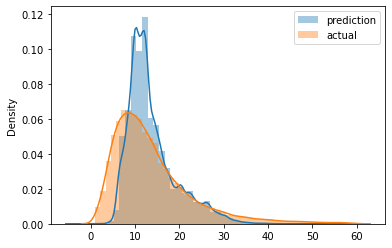

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet')

In [12]:
len(df_train), len(df_val)

(54373, 51497)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

sqrt(mean_squared_error(y_val, y_pred))

5.982652114977233

In [18]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [21]:
with mlflow.start_run():
    mlflow.set_tag("developer","Gunasekaran")
    mlflow.log_param("train_data_url","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet")
    mlflow.log_param("valid_data_url","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet")
    alpha=0.01
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    mse=sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse",mse)

In [23]:
import xgboost as xgb

In [25]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [26]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [27]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [28]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|                                                                                             | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:08:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.62021                                                                                                              
[1]	validation-rmse:5.69891                                                                                                              
[2]	validation-rmse:5.37844                                                                                                              
[3]	validation-rmse:5.27331                                                                                                              
[4]	validation-rmse:5.22729                                                                                                              
[5]	validation-rmse:5.21412                                                                                                              
[6]	validation-rmse:5.19866                                                                                                              
[7]	validation-rmse:5.19604       

[59]	validation-rmse:5.21211                                                                                                             
[60]	validation-rmse:5.21333                                                                                                             
[61]	validation-rmse:5.21510                                                                                                             
[62]	validation-rmse:5.21626                                                                                                             
[63]	validation-rmse:5.21527                                                                                                             
[64]	validation-rmse:5.21595                                                                                                             
[65]	validation-rmse:5.21620                                                                                                             
[66]	validation-rmse:5.21632      

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:08:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.06909                                                                                                              
[3]	validation-rmse:5.78155                                                                                                              
[4]	validation-rmse:5.63174                                                                                                              
[5]	validation-rmse:5.55051                                                                                                              
[6]	validation-rmse:5.50658                                                                                                              
[7]	validation-rmse:5.48705                                                                                                              
[8]	validation-rmse:5.46063                                                                                                              
[9]	validation-rmse:5.45152       

[61]	validation-rmse:5.38821                                                                                                             
[62]	validation-rmse:5.38838                                                                                                             
[63]	validation-rmse:5.38684                                                                                                             
[64]	validation-rmse:5.38632                                                                                                             
[65]	validation-rmse:5.38527                                                                                                             
[66]	validation-rmse:5.38455                                                                                                             
[67]	validation-rmse:5.38430                                                                                                             
[68]	validation-rmse:5.38365      

[120]	validation-rmse:5.34108                                                                                                            
[121]	validation-rmse:5.34051                                                                                                            
[122]	validation-rmse:5.34004                                                                                                            
[123]	validation-rmse:5.33917                                                                                                            
[124]	validation-rmse:5.33908                                                                                                            
[125]	validation-rmse:5.33867                                                                                                            
[126]	validation-rmse:5.33780                                                                                                            
[127]	validation-rmse:5.33711     

[179]	validation-rmse:5.31157                                                                                                            
[180]	validation-rmse:5.31054                                                                                                            
[181]	validation-rmse:5.31057                                                                                                            
[182]	validation-rmse:5.30950                                                                                                            
[183]	validation-rmse:5.30982                                                                                                            
[184]	validation-rmse:5.31051                                                                                                            
[185]	validation-rmse:5.31042                                                                                                            
[186]	validation-rmse:5.30970     

[238]	validation-rmse:5.28849                                                                                                            
[239]	validation-rmse:5.28851                                                                                                            
[240]	validation-rmse:5.28795                                                                                                            
[241]	validation-rmse:5.28859                                                                                                            
[242]	validation-rmse:5.28903                                                                                                            
[243]	validation-rmse:5.28833                                                                                                            
[244]	validation-rmse:5.28745                                                                                                            
[245]	validation-rmse:5.28732     

[297]	validation-rmse:5.27402                                                                                                            
[298]	validation-rmse:5.27375                                                                                                            
[299]	validation-rmse:5.27395                                                                                                            
[300]	validation-rmse:5.27429                                                                                                            
[301]	validation-rmse:5.27419                                                                                                            
[302]	validation-rmse:5.27431                                                                                                            
[303]	validation-rmse:5.27405                                                                                                            
[304]	validation-rmse:5.27394     

[356]	validation-rmse:5.26999                                                                                                            
[357]	validation-rmse:5.27015                                                                                                            
[358]	validation-rmse:5.27015                                                                                                            
[359]	validation-rmse:5.27108                                                                                                            
[360]	validation-rmse:5.27100                                                                                                            
[361]	validation-rmse:5.27126                                                                                                            
[362]	validation-rmse:5.27076                                                                                                            
[363]	validation-rmse:5.27064     

[415]	validation-rmse:5.26148                                                                                                            
[416]	validation-rmse:5.26085                                                                                                            
[417]	validation-rmse:5.26040                                                                                                            
[418]	validation-rmse:5.26044                                                                                                            
[419]	validation-rmse:5.26042                                                                                                            
[420]	validation-rmse:5.25993                                                                                                            
[421]	validation-rmse:5.25959                                                                                                            
[422]	validation-rmse:5.25983     

[474]	validation-rmse:5.26235                                                                                                            
[475]	validation-rmse:5.26211                                                                                                            
[476]	validation-rmse:5.26263                                                                                                            
[477]	validation-rmse:5.26262                                                                                                            
[478]	validation-rmse:5.26292                                                                                                            
[479]	validation-rmse:5.26291                                                                                                            
[480]	validation-rmse:5.26307                                                                                                            
[481]	validation-rmse:5.26328     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:08:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.33239                                                                                                              
[1]	validation-rmse:5.60227                                                                                                              
[2]	validation-rmse:5.43872                                                                                                              
[3]	validation-rmse:5.39976                                                                                                              
[4]	validation-rmse:5.38352                                                                                                              
[5]	validation-rmse:5.37894                                                                                                              
[6]	validation-rmse:5.36692                                                                                                              
[7]	validation-rmse:5.36277       

[59]	validation-rmse:5.40686                                                                                                             
[60]	validation-rmse:5.40800                                                                                                             
[61]	validation-rmse:5.40848                                                                                                             
[62]	validation-rmse:5.40988                                                                                                             
[63]	validation-rmse:5.41117                                                                                                             
[64]	validation-rmse:5.41182                                                                                                             
[65]	validation-rmse:5.41317                                                                                                             
[66]	validation-rmse:5.41453      

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:09:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.58485                                                                                                              
[1]	validation-rmse:6.61473                                                                                                              
[2]	validation-rmse:6.02417                                                                                                              
[3]	validation-rmse:5.68065                                                                                                              
[4]	validation-rmse:5.48525                                                                                                              
[5]	validation-rmse:5.37737                                                                                                              
[6]	validation-rmse:5.31841                                                                                                              
[7]	validation-rmse:5.28593       

[59]	validation-rmse:5.20816                                                                                                             
[60]	validation-rmse:5.20852                                                                                                             
[61]	validation-rmse:5.20926                                                                                                             
[62]	validation-rmse:5.20782                                                                                                             
[63]	validation-rmse:5.20805                                                                                                             
[64]	validation-rmse:5.20804                                                                                                             
[65]	validation-rmse:5.20819                                                                                                             
[66]	validation-rmse:5.20835      

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:09:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.34696                                                                                                              
[1]	validation-rmse:7.71682                                                                                                              
[2]	validation-rmse:7.21700                                                                                                              
[3]	validation-rmse:6.80777                                                                                                              
[4]	validation-rmse:6.48327                                                                                                              
[5]	validation-rmse:6.23287                                                                                                              
[6]	validation-rmse:6.03570                                                                                                              
[7]	validation-rmse:5.87396       

[59]	validation-rmse:5.31641                                                                                                             
[60]	validation-rmse:5.31703                                                                                                             
[61]	validation-rmse:5.31641                                                                                                             
[62]	validation-rmse:5.31660                                                                                                             
[63]	validation-rmse:5.31623                                                                                                             
[64]	validation-rmse:5.31599                                                                                                             
[65]	validation-rmse:5.31656                                                                                                             
[66]	validation-rmse:5.31576      

[118]	validation-rmse:5.31397                                                                                                            
[119]	validation-rmse:5.31403                                                                                                            
[120]	validation-rmse:5.31421                                                                                                            
[121]	validation-rmse:5.31456                                                                                                            
[122]	validation-rmse:5.31440                                                                                                            
[123]	validation-rmse:5.31460                                                                                                            
[124]	validation-rmse:5.31458                                                                                                            
[125]	validation-rmse:5.31460     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:11:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.15447                                                                                                              
[1]	validation-rmse:7.41710                                                                                                              
[2]	validation-rmse:6.85763                                                                                                              
[3]	validation-rmse:6.43957                                                                                                              
[4]	validation-rmse:6.13142                                                                                                              
[5]	validation-rmse:5.90414                                                                                                              
[6]	validation-rmse:5.74201                                                                                                              
[7]	validation-rmse:5.62423       

[59]	validation-rmse:5.24157                                                                                                             
[60]	validation-rmse:5.24137                                                                                                             
[61]	validation-rmse:5.24011                                                                                                             
[62]	validation-rmse:5.23985                                                                                                             
[63]	validation-rmse:5.23873                                                                                                             
[64]	validation-rmse:5.23852                                                                                                             
[65]	validation-rmse:5.23772                                                                                                             
[66]	validation-rmse:5.23715      

[118]	validation-rmse:5.21949                                                                                                            
[119]	validation-rmse:5.21926                                                                                                            
[120]	validation-rmse:5.21896                                                                                                            
[121]	validation-rmse:5.21903                                                                                                            
[122]	validation-rmse:5.21892                                                                                                            
[123]	validation-rmse:5.21825                                                                                                            
[124]	validation-rmse:5.21792                                                                                                            
[125]	validation-rmse:5.21807     

[177]	validation-rmse:5.21288                                                                                                            
[178]	validation-rmse:5.21266                                                                                                            
[179]	validation-rmse:5.21277                                                                                                            
[180]	validation-rmse:5.21273                                                                                                            
[181]	validation-rmse:5.21244                                                                                                            
[182]	validation-rmse:5.21221                                                                                                            
[183]	validation-rmse:5.21208                                                                                                            
[184]	validation-rmse:5.21236     

[236]	validation-rmse:5.20748                                                                                                            
[237]	validation-rmse:5.20738                                                                                                            
[238]	validation-rmse:5.20732                                                                                                            
[239]	validation-rmse:5.20717                                                                                                            
[240]	validation-rmse:5.20737                                                                                                            
[241]	validation-rmse:5.20730                                                                                                            
[242]	validation-rmse:5.20748                                                                                                            
[243]	validation-rmse:5.20755     

[295]	validation-rmse:5.20501                                                                                                            
[296]	validation-rmse:5.20506                                                                                                            
[297]	validation-rmse:5.20477                                                                                                            
[298]	validation-rmse:5.20492                                                                                                            
[299]	validation-rmse:5.20493                                                                                                            
[300]	validation-rmse:5.20463                                                                                                            
[301]	validation-rmse:5.20464                                                                                                            
[302]	validation-rmse:5.20490     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:11:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.45603                                                                                                              
[1]	validation-rmse:5.40562                                                                                                              
[2]	validation-rmse:5.38969                                                                                                              
[3]	validation-rmse:5.37467                                                                                                              
[4]	validation-rmse:5.36465                                                                                                              
[5]	validation-rmse:5.34482                                                                                                              
[6]	validation-rmse:5.33596                                                                                                              
[7]	validation-rmse:5.33018       

[59]	validation-rmse:5.26717                                                                                                             
[60]	validation-rmse:5.26522                                                                                                             
[61]	validation-rmse:5.26535                                                                                                             
[62]	validation-rmse:5.26467                                                                                                             
[63]	validation-rmse:5.26431                                                                                                             
[64]	validation-rmse:5.26480                                                                                                             
[65]	validation-rmse:5.26477                                                                                                             
[66]	validation-rmse:5.26369      

[118]	validation-rmse:5.26038                                                                                                            
[119]	validation-rmse:5.26015                                                                                                            
[120]	validation-rmse:5.25992                                                                                                            
[121]	validation-rmse:5.25997                                                                                                            
[122]	validation-rmse:5.25992                                                                                                            
[123]	validation-rmse:5.25910                                                                                                            
[124]	validation-rmse:5.25933                                                                                                            
[125]	validation-rmse:5.25968     

[177]	validation-rmse:5.26161                                                                                                            
[178]	validation-rmse:5.26260                                                                                                            
[179]	validation-rmse:5.26255                                                                                                            
[180]	validation-rmse:5.26293                                                                                                            
[181]	validation-rmse:5.26318                                                                                                            
[182]	validation-rmse:5.26349                                                                                                            
[183]	validation-rmse:5.26318                                                                                                            
[184]	validation-rmse:5.26306     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:12:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.02265                                                                                                              
[1]	validation-rmse:7.22161                                                                                                              
[2]	validation-rmse:6.65308                                                                                                              
[3]	validation-rmse:6.25524                                                                                                              
[4]	validation-rmse:5.96884                                                                                                              
[5]	validation-rmse:5.77630                                                                                                              
[6]	validation-rmse:5.64413                                                                                                              
[7]	validation-rmse:5.55434       

[59]	validation-rmse:5.27626                                                                                                             
[60]	validation-rmse:5.27558                                                                                                             
[61]	validation-rmse:5.27384                                                                                                             
[62]	validation-rmse:5.27312                                                                                                             
[63]	validation-rmse:5.27265                                                                                                             
[64]	validation-rmse:5.27174                                                                                                             
[65]	validation-rmse:5.27109                                                                                                             
[66]	validation-rmse:5.26999      

[118]	validation-rmse:5.25333                                                                                                            
[119]	validation-rmse:5.25263                                                                                                            
[120]	validation-rmse:5.25187                                                                                                            
[121]	validation-rmse:5.25176                                                                                                            
[122]	validation-rmse:5.25147                                                                                                            
[123]	validation-rmse:5.25114                                                                                                            
[124]	validation-rmse:5.25091                                                                                                            
[125]	validation-rmse:5.25093     

[177]	validation-rmse:5.24165                                                                                                            
[178]	validation-rmse:5.24154                                                                                                            
[179]	validation-rmse:5.24124                                                                                                            
[180]	validation-rmse:5.24063                                                                                                            
[181]	validation-rmse:5.23996                                                                                                            
[182]	validation-rmse:5.24026                                                                                                            
[183]	validation-rmse:5.23844                                                                                                            
[184]	validation-rmse:5.23821     

[236]	validation-rmse:5.23652                                                                                                            
[237]	validation-rmse:5.23677                                                                                                            
[238]	validation-rmse:5.23681                                                                                                            
[239]	validation-rmse:5.23629                                                                                                            
[240]	validation-rmse:5.23665                                                                                                            
[241]	validation-rmse:5.23648                                                                                                            
[242]	validation-rmse:5.23664                                                                                                            
[243]	validation-rmse:5.23705     

[295]	validation-rmse:5.23635                                                                                                            
[296]	validation-rmse:5.23668                                                                                                            
[297]	validation-rmse:5.23643                                                                                                            
[298]	validation-rmse:5.23718                                                                                                            
[299]	validation-rmse:5.23715                                                                                                            
[300]	validation-rmse:5.23732                                                                                                            
[301]	validation-rmse:5.23719                                                                                                            
[302]	validation-rmse:5.23725     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:12:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.92898                                                                                                              
[1]	validation-rmse:7.08326                                                                                                              
[2]	validation-rmse:6.51370                                                                                                              
[3]	validation-rmse:6.11315                                                                                                              
[4]	validation-rmse:5.83879                                                                                                              
[5]	validation-rmse:5.66777                                                                                                              
[6]	validation-rmse:5.56305                                                                                                              
[7]	validation-rmse:5.47810       

[59]	validation-rmse:5.32484                                                                                                             
[60]	validation-rmse:5.32504                                                                                                             
[61]	validation-rmse:5.32482                                                                                                             
[62]	validation-rmse:5.32462                                                                                                             
[63]	validation-rmse:5.32535                                                                                                             
[64]	validation-rmse:5.32534                                                                                                             
[65]	validation-rmse:5.32520                                                                                                             
[66]	validation-rmse:5.32538      

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:13:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.40801                                                                                                              
[1]	validation-rmse:7.83083                                                                                                              
[2]	validation-rmse:7.34995                                                                                                              
[3]	validation-rmse:6.95979                                                                                                              
[4]	validation-rmse:6.63140                                                                                                              
[5]	validation-rmse:6.38002                                                                                                              
[6]	validation-rmse:6.15514                                                                                                              
[7]	validation-rmse:5.99306       

[59]	validation-rmse:5.27862                                                                                                             
[60]	validation-rmse:5.27826                                                                                                             
[61]	validation-rmse:5.27818                                                                                                             
[62]	validation-rmse:5.27739                                                                                                             
[63]	validation-rmse:5.27672                                                                                                             
[64]	validation-rmse:5.27676                                                                                                             
[65]	validation-rmse:5.27625                                                                                                             
[66]	validation-rmse:5.27700      

[118]	validation-rmse:5.26860                                                                                                            
[119]	validation-rmse:5.26901                                                                                                            
[120]	validation-rmse:5.26938                                                                                                            
[121]	validation-rmse:5.26905                                                                                                            
[122]	validation-rmse:5.26885                                                                                                            
[123]	validation-rmse:5.26879                                                                                                            
[124]	validation-rmse:5.26868                                                                                                            
[125]	validation-rmse:5.26893     

[177]	validation-rmse:5.26946                                                                                                            
[178]	validation-rmse:5.26937                                                                                                            
[179]	validation-rmse:5.26937                                                                                                            
[180]	validation-rmse:5.26988                                                                                                            
[181]	validation-rmse:5.27002                                                                                                            
[182]	validation-rmse:5.27010                                                                                                            
[183]	validation-rmse:5.27008                                                                                                            
[184]	validation-rmse:5.26994     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:14:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.53477                                                                                                              
[1]	validation-rmse:5.44457                                                                                                              
[2]	validation-rmse:5.43203                                                                                                              
[3]	validation-rmse:5.43275                                                                                                              
[4]	validation-rmse:5.42606                                                                                                              
[5]	validation-rmse:5.42248                                                                                                              
[6]	validation-rmse:5.42251                                                                                                              
[7]	validation-rmse:5.41763       

[59]	validation-rmse:5.50490                                                                                                             
[60]	validation-rmse:5.50876                                                                                                             
[61]	validation-rmse:5.51001                                                                                                             
[62]	validation-rmse:5.51386                                                                                                             
[63]	validation-rmse:5.51589                                                                                                             
 22%|██████████████▋                                                    | 11/50 [06:34<24:34, 37.80s/trial, best loss: 5.204968035931017]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:14:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.07610                                                                                                              
[1]	validation-rmse:6.05753                                                                                                              
[2]	validation-rmse:5.59335                                                                                                              
[3]	validation-rmse:5.39189                                                                                                              
[4]	validation-rmse:5.30971                                                                                                              
[5]	validation-rmse:5.27492                                                                                                              
[6]	validation-rmse:5.25807                                                                                                              
[7]	validation-rmse:5.24614       

[59]	validation-rmse:5.20724                                                                                                             
[60]	validation-rmse:5.20828                                                                                                             
[61]	validation-rmse:5.20863                                                                                                             
[62]	validation-rmse:5.20861                                                                                                             
[63]	validation-rmse:5.20814                                                                                                             
[64]	validation-rmse:5.20857                                                                                                             
[65]	validation-rmse:5.20800                                                                                                             
[66]	validation-rmse:5.20890      

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:15:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.72573                                                                                                              
[1]	validation-rmse:8.37489                                                                                                              
[2]	validation-rmse:8.05470                                                                                                              
[3]	validation-rmse:7.76451                                                                                                              
[4]	validation-rmse:7.50039                                                                                                              
[5]	validation-rmse:7.26212                                                                                                              
[6]	validation-rmse:7.04659                                                                                                              
[7]	validation-rmse:6.85247       

[59]	validation-rmse:5.18190                                                                                                             
[60]	validation-rmse:5.18093                                                                                                             
[61]	validation-rmse:5.18009                                                                                                             
[62]	validation-rmse:5.17923                                                                                                             
[63]	validation-rmse:5.17832                                                                                                             
[64]	validation-rmse:5.17769                                                                                                             
[65]	validation-rmse:5.17741                                                                                                             
[66]	validation-rmse:5.17689      

[118]	validation-rmse:5.16815                                                                                                            
[119]	validation-rmse:5.16812                                                                                                            
[120]	validation-rmse:5.16797                                                                                                            
[121]	validation-rmse:5.16795                                                                                                            
[122]	validation-rmse:5.16785                                                                                                            
[123]	validation-rmse:5.16775                                                                                                            
[124]	validation-rmse:5.16763                                                                                                            
[125]	validation-rmse:5.16753     

[177]	validation-rmse:5.16267                                                                                                            
[178]	validation-rmse:5.16255                                                                                                            
[179]	validation-rmse:5.16262                                                                                                            
[180]	validation-rmse:5.16254                                                                                                            
[181]	validation-rmse:5.16251                                                                                                            
[182]	validation-rmse:5.16261                                                                                                            
[183]	validation-rmse:5.16246                                                                                                            
[184]	validation-rmse:5.16243     

[236]	validation-rmse:5.16027                                                                                                            
[237]	validation-rmse:5.16024                                                                                                            
[238]	validation-rmse:5.16028                                                                                                            
[239]	validation-rmse:5.16023                                                                                                            
[240]	validation-rmse:5.16030                                                                                                            
[241]	validation-rmse:5.16011                                                                                                            
[242]	validation-rmse:5.16012                                                                                                            
[243]	validation-rmse:5.16027     

[295]	validation-rmse:5.16005                                                                                                            
[296]	validation-rmse:5.16019                                                                                                            
[297]	validation-rmse:5.15998                                                                                                            
[298]	validation-rmse:5.16000                                                                                                            
[299]	validation-rmse:5.15980                                                                                                            
[300]	validation-rmse:5.15988                                                                                                            
[301]	validation-rmse:5.15986                                                                                                            
[302]	validation-rmse:5.15991     

[354]	validation-rmse:5.16080                                                                                                            
 26%|█████████████████▍                                                 | 13/50 [08:19<29:13, 47.39s/trial, best loss: 5.160798660469143]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:16:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.54370                                                                                                              
[1]	validation-rmse:8.04889                                                                                                              
[2]	validation-rmse:7.62041                                                                                                              
[3]	validation-rmse:7.25112                                                                                                              
[4]	validation-rmse:6.93254                                                                                                              
[5]	validation-rmse:6.66140                                                                                                              
[6]	validation-rmse:6.42949                                                                                                              
[7]	validation-rmse:6.23293       

[59]	validation-rmse:5.20481                                                                                                             
[60]	validation-rmse:5.20450                                                                                                             
[61]	validation-rmse:5.20423                                                                                                             
[62]	validation-rmse:5.20428                                                                                                             
[63]	validation-rmse:5.20424                                                                                                             
[64]	validation-rmse:5.20359                                                                                                             
[65]	validation-rmse:5.20359                                                                                                             
[66]	validation-rmse:5.20376      

[118]	validation-rmse:5.18924                                                                                                            
[119]	validation-rmse:5.18913                                                                                                            
[120]	validation-rmse:5.18923                                                                                                            
[121]	validation-rmse:5.18834                                                                                                            
[122]	validation-rmse:5.18852                                                                                                            
[123]	validation-rmse:5.18850                                                                                                            
[124]	validation-rmse:5.18850                                                                                                            
[125]	validation-rmse:5.18851     

[177]	validation-rmse:5.18307                                                                                                            
[178]	validation-rmse:5.18302                                                                                                            
[179]	validation-rmse:5.18307                                                                                                            
[180]	validation-rmse:5.18306                                                                                                            
[181]	validation-rmse:5.18313                                                                                                            
[182]	validation-rmse:5.18299                                                                                                            
[183]	validation-rmse:5.18252                                                                                                            
[184]	validation-rmse:5.18243     

[236]	validation-rmse:5.18172                                                                                                            
[237]	validation-rmse:5.18184                                                                                                            
[238]	validation-rmse:5.18206                                                                                                            
[239]	validation-rmse:5.18212                                                                                                            
[240]	validation-rmse:5.18229                                                                                                            
[241]	validation-rmse:5.18218                                                                                                            
[242]	validation-rmse:5.18214                                                                                                            
[243]	validation-rmse:5.18210     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:17:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.74959                                                                                                              
[1]	validation-rmse:6.84835                                                                                                              
[2]	validation-rmse:6.27375                                                                                                              
[3]	validation-rmse:5.91848                                                                                                              
[4]	validation-rmse:5.69967                                                                                                              
[5]	validation-rmse:5.56338                                                                                                              
[6]	validation-rmse:5.48177                                                                                                              
[7]	validation-rmse:5.43079       

[59]	validation-rmse:5.26083                                                                                                             
[60]	validation-rmse:5.26088                                                                                                             
[61]	validation-rmse:5.26091                                                                                                             
[62]	validation-rmse:5.26062                                                                                                             
[63]	validation-rmse:5.26067                                                                                                             
[64]	validation-rmse:5.26036                                                                                                             
[65]	validation-rmse:5.26048                                                                                                             
[66]	validation-rmse:5.26014      

[118]	validation-rmse:5.24491                                                                                                            
[119]	validation-rmse:5.24502                                                                                                            
[120]	validation-rmse:5.24491                                                                                                            
[121]	validation-rmse:5.24386                                                                                                            
[122]	validation-rmse:5.24411                                                                                                            
[123]	validation-rmse:5.24449                                                                                                            
[124]	validation-rmse:5.24385                                                                                                            
[125]	validation-rmse:5.24467     

[177]	validation-rmse:5.23477                                                                                                            
[178]	validation-rmse:5.23502                                                                                                            
[179]	validation-rmse:5.23510                                                                                                            
[180]	validation-rmse:5.23502                                                                                                            
[181]	validation-rmse:5.23506                                                                                                            
[182]	validation-rmse:5.23507                                                                                                            
[183]	validation-rmse:5.23442                                                                                                            
[184]	validation-rmse:5.23418     

[236]	validation-rmse:5.23209                                                                                                            
[237]	validation-rmse:5.23233                                                                                                            
[238]	validation-rmse:5.23194                                                                                                            
[239]	validation-rmse:5.23211                                                                                                            
[240]	validation-rmse:5.23180                                                                                                            
[241]	validation-rmse:5.23212                                                                                                            
[242]	validation-rmse:5.23194                                                                                                            
[243]	validation-rmse:5.23158     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:18:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:5.42302                                                                                                              
[4]	validation-rmse:5.41482                                                                                                              
[5]	validation-rmse:5.40668                                                                                                              
[6]	validation-rmse:5.40493                                                                                                              
[7]	validation-rmse:5.39940                                                                                                              
[8]	validation-rmse:5.39361                                                                                                              
[9]	validation-rmse:5.38765                                                                                                              
[10]	validation-rmse:5.37853      

[62]	validation-rmse:5.25499                                                                                                             
[63]	validation-rmse:5.25472                                                                                                             
[64]	validation-rmse:5.25390                                                                                                             
[65]	validation-rmse:5.25426                                                                                                             
[66]	validation-rmse:5.25471                                                                                                             
[67]	validation-rmse:5.25418                                                                                                             
[68]	validation-rmse:5.25405                                                                                                             
[69]	validation-rmse:5.25456      

[121]	validation-rmse:5.23958                                                                                                            
[122]	validation-rmse:5.23927                                                                                                            
[123]	validation-rmse:5.23880                                                                                                            
[124]	validation-rmse:5.23792                                                                                                            
[125]	validation-rmse:5.23918                                                                                                            
[126]	validation-rmse:5.23789                                                                                                            
[127]	validation-rmse:5.23937                                                                                                            
[128]	validation-rmse:5.23842     

[180]	validation-rmse:5.23221                                                                                                            
[181]	validation-rmse:5.23197                                                                                                            
[182]	validation-rmse:5.23245                                                                                                            
[183]	validation-rmse:5.23275                                                                                                            
[184]	validation-rmse:5.23289                                                                                                            
[185]	validation-rmse:5.23318                                                                                                            
[186]	validation-rmse:5.23221                                                                                                            
[187]	validation-rmse:5.23302     

[239]	validation-rmse:5.22611                                                                                                            
[240]	validation-rmse:5.22644                                                                                                            
[241]	validation-rmse:5.22635                                                                                                            
[242]	validation-rmse:5.22638                                                                                                            
[243]	validation-rmse:5.22723                                                                                                            
[244]	validation-rmse:5.22699                                                                                                            
[245]	validation-rmse:5.22706                                                                                                            
[246]	validation-rmse:5.22678     

[298]	validation-rmse:5.22588                                                                                                            
[299]	validation-rmse:5.22638                                                                                                            
[300]	validation-rmse:5.22669                                                                                                            
[301]	validation-rmse:5.22680                                                                                                            
[302]	validation-rmse:5.22703                                                                                                            
[303]	validation-rmse:5.22672                                                                                                            
[304]	validation-rmse:5.22702                                                                                                            
[305]	validation-rmse:5.22751     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:18:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.15801                                                                                                              
[1]	validation-rmse:7.42071                                                                                                              
[2]	validation-rmse:6.85831                                                                                                              
[3]	validation-rmse:6.43765                                                                                                              
[4]	validation-rmse:6.12457                                                                                                              
[5]	validation-rmse:5.89601                                                                                                              
[6]	validation-rmse:5.73033                                                                                                              
[7]	validation-rmse:5.60961       

[59]	validation-rmse:5.22800                                                                                                             
[60]	validation-rmse:5.22760                                                                                                             
[61]	validation-rmse:5.22633                                                                                                             
[62]	validation-rmse:5.22603                                                                                                             
[63]	validation-rmse:5.22606                                                                                                             
[64]	validation-rmse:5.22516                                                                                                             
[65]	validation-rmse:5.22490                                                                                                             
[66]	validation-rmse:5.22427      

[118]	validation-rmse:5.20900                                                                                                            
[119]	validation-rmse:5.20875                                                                                                            
[120]	validation-rmse:5.20876                                                                                                            
[121]	validation-rmse:5.20829                                                                                                            
[122]	validation-rmse:5.20746                                                                                                            
[123]	validation-rmse:5.20741                                                                                                            
[124]	validation-rmse:5.20725                                                                                                            
[125]	validation-rmse:5.20722     

[177]	validation-rmse:5.20050                                                                                                            
[178]	validation-rmse:5.20049                                                                                                            
[179]	validation-rmse:5.20030                                                                                                            
[180]	validation-rmse:5.20017                                                                                                            
[181]	validation-rmse:5.19991                                                                                                            
[182]	validation-rmse:5.20032                                                                                                            
[183]	validation-rmse:5.20039                                                                                                            
[184]	validation-rmse:5.20025     

[236]	validation-rmse:5.19712                                                                                                            
[237]	validation-rmse:5.19702                                                                                                            
[238]	validation-rmse:5.19733                                                                                                            
[239]	validation-rmse:5.19701                                                                                                            
[240]	validation-rmse:5.19709                                                                                                            
[241]	validation-rmse:5.19732                                                                                                            
[242]	validation-rmse:5.19702                                                                                                            
[243]	validation-rmse:5.19683     

[295]	validation-rmse:5.19671                                                                                                            
[296]	validation-rmse:5.19676                                                                                                            
[297]	validation-rmse:5.19686                                                                                                            
[298]	validation-rmse:5.19673                                                                                                            
[299]	validation-rmse:5.19694                                                                                                            
[300]	validation-rmse:5.19689                                                                                                            
[301]	validation-rmse:5.19699                                                                                                            
[302]	validation-rmse:5.19700     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:19:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.62774                                                                                                              
[1]	validation-rmse:5.76468                                                                                                              
[2]	validation-rmse:5.49499                                                                                                              
[3]	validation-rmse:5.39699                                                                                                              
[4]	validation-rmse:5.36492                                                                                                              
[5]	validation-rmse:5.34933                                                                                                              
[6]	validation-rmse:5.33535                                                                                                              
[7]	validation-rmse:5.33226       

[59]	validation-rmse:5.26178                                                                                                             
[60]	validation-rmse:5.26126                                                                                                             
[61]	validation-rmse:5.25969                                                                                                             
[62]	validation-rmse:5.26053                                                                                                             
[63]	validation-rmse:5.25907                                                                                                             
[64]	validation-rmse:5.25735                                                                                                             
[65]	validation-rmse:5.25692                                                                                                             
[66]	validation-rmse:5.25654      

[118]	validation-rmse:5.25166                                                                                                            
[119]	validation-rmse:5.25169                                                                                                            
[120]	validation-rmse:5.25209                                                                                                            
[121]	validation-rmse:5.25249                                                                                                            
[122]	validation-rmse:5.25174                                                                                                            
[123]	validation-rmse:5.25194                                                                                                            
[124]	validation-rmse:5.25171                                                                                                            
[125]	validation-rmse:5.25221     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:19:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.79432                                                                                                              
[1]	validation-rmse:5.33625                                                                                                              
[2]	validation-rmse:5.26571                                                                                                              
[3]	validation-rmse:5.24511                                                                                                              
[4]	validation-rmse:5.24319                                                                                                              
[5]	validation-rmse:5.23838                                                                                                              
[6]	validation-rmse:5.22781                                                                                                              
[7]	validation-rmse:5.22071       

[59]	validation-rmse:5.18510                                                                                                             
[60]	validation-rmse:5.18506                                                                                                             
[61]	validation-rmse:5.18509                                                                                                             
[62]	validation-rmse:5.18567                                                                                                             
[63]	validation-rmse:5.18610                                                                                                             
[64]	validation-rmse:5.18642                                                                                                             
[65]	validation-rmse:5.18731                                                                                                             
[66]	validation-rmse:5.18830      

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:20:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:5.58877                                                                                                              
[3]	validation-rmse:5.47015                                                                                                              
[4]	validation-rmse:5.41947                                                                                                              
[5]	validation-rmse:5.39339                                                                                                              
[6]	validation-rmse:5.38097                                                                                                              
[7]	validation-rmse:5.36869                                                                                                              
[8]	validation-rmse:5.36382                                                                                                              
[9]	validation-rmse:5.35811       

[61]	validation-rmse:5.22840                                                                                                             
[62]	validation-rmse:5.22500                                                                                                             
[63]	validation-rmse:5.22389                                                                                                             
[64]	validation-rmse:5.21993                                                                                                             
[65]	validation-rmse:5.21942                                                                                                             
[66]	validation-rmse:5.21851                                                                                                             
[67]	validation-rmse:5.21776                                                                                                             
[68]	validation-rmse:5.21572      

[120]	validation-rmse:5.18681                                                                                                            
[121]	validation-rmse:5.18680                                                                                                            
[122]	validation-rmse:5.18662                                                                                                            
[123]	validation-rmse:5.18664                                                                                                            
[124]	validation-rmse:5.18163                                                                                                            
[125]	validation-rmse:5.18055                                                                                                            
[126]	validation-rmse:5.17905                                                                                                            
[127]	validation-rmse:5.17907     

[179]	validation-rmse:5.16832                                                                                                            
[180]	validation-rmse:5.16824                                                                                                            
[181]	validation-rmse:5.16724                                                                                                            
[182]	validation-rmse:5.16749                                                                                                            
[183]	validation-rmse:5.16745                                                                                                            
[184]	validation-rmse:5.16749                                                                                                            
[185]	validation-rmse:5.16760                                                                                                            
[186]	validation-rmse:5.16715     

[238]	validation-rmse:5.16558                                                                                                            
[239]	validation-rmse:5.16529                                                                                                            
[240]	validation-rmse:5.16488                                                                                                            
[241]	validation-rmse:5.16515                                                                                                            
[242]	validation-rmse:5.16459                                                                                                            
[243]	validation-rmse:5.16153                                                                                                            
[244]	validation-rmse:5.16157                                                                                                            
[245]	validation-rmse:5.16170     

[297]	validation-rmse:5.16112                                                                                                            
[298]	validation-rmse:5.16067                                                                                                            
[299]	validation-rmse:5.16073                                                                                                            
[300]	validation-rmse:5.16105                                                                                                            
[301]	validation-rmse:5.16170                                                                                                            
[302]	validation-rmse:5.16169                                                                                                            
[303]	validation-rmse:5.16156                                                                                                            
[304]	validation-rmse:5.16161     

[356]	validation-rmse:5.15582                                                                                                            
[357]	validation-rmse:5.15598                                                                                                            
[358]	validation-rmse:5.15603                                                                                                            
[359]	validation-rmse:5.15572                                                                                                            
[360]	validation-rmse:5.15580                                                                                                            
[361]	validation-rmse:5.15550                                                                                                            
[362]	validation-rmse:5.15527                                                                                                            
[363]	validation-rmse:5.15548     

[415]	validation-rmse:5.15397                                                                                                            
[416]	validation-rmse:5.15360                                                                                                            
[417]	validation-rmse:5.15325                                                                                                            
[418]	validation-rmse:5.15355                                                                                                            
[419]	validation-rmse:5.15301                                                                                                            
[420]	validation-rmse:5.15305                                                                                                            
[421]	validation-rmse:5.15311                                                                                                            
[422]	validation-rmse:5.15311     

 40%|██████████████████████████▊                                        | 20/50 [12:04<12:53, 25.77s/trial, best loss: 5.154871221309194]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:20:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.70123                                                                                                              
[1]	validation-rmse:8.33078                                                                                                              
[2]	validation-rmse:7.99674                                                                                                              
[3]	validation-rmse:7.69538                                                                                                              
[4]	validation-rmse:7.42550                                                                                                              
[5]	validation-rmse:7.18299                                                                                                              
[6]	validation-rmse:6.96583                                                                                                              
[7]	validation-rmse:6.77297       

[59]	validation-rmse:5.25750                                                                                                             
[60]	validation-rmse:5.25629                                                                                                             
[61]	validation-rmse:5.25514                                                                                                             
[62]	validation-rmse:5.25408                                                                                                             
[63]	validation-rmse:5.25319                                                                                                             
[64]	validation-rmse:5.25263                                                                                                             
[65]	validation-rmse:5.25183                                                                                                             
[66]	validation-rmse:5.25071      

[118]	validation-rmse:5.22609                                                                                                            
[119]	validation-rmse:5.22601                                                                                                            
[120]	validation-rmse:5.22555                                                                                                            
[121]	validation-rmse:5.22529                                                                                                            
[122]	validation-rmse:5.22516                                                                                                            
[123]	validation-rmse:5.22492                                                                                                            
[124]	validation-rmse:5.22479                                                                                                            
[125]	validation-rmse:5.22447     

[177]	validation-rmse:5.21042                                                                                                            
[178]	validation-rmse:5.21036                                                                                                            
[179]	validation-rmse:5.20931                                                                                                            
[180]	validation-rmse:5.20920                                                                                                            
[181]	validation-rmse:5.20897                                                                                                            
[182]	validation-rmse:5.20866                                                                                                            
[183]	validation-rmse:5.20831                                                                                                            
[184]	validation-rmse:5.20819     

[236]	validation-rmse:5.19659                                                                                                            
[237]	validation-rmse:5.19644                                                                                                            
[238]	validation-rmse:5.19624                                                                                                            
[239]	validation-rmse:5.19620                                                                                                            
[240]	validation-rmse:5.19619                                                                                                            
[241]	validation-rmse:5.19614                                                                                                            
[242]	validation-rmse:5.19574                                                                                                            
[243]	validation-rmse:5.19541     

[295]	validation-rmse:5.18791                                                                                                            
[296]	validation-rmse:5.18790                                                                                                            
[297]	validation-rmse:5.18787                                                                                                            
[298]	validation-rmse:5.18772                                                                                                            
[299]	validation-rmse:5.18768                                                                                                            
[300]	validation-rmse:5.18754                                                                                                            
[301]	validation-rmse:5.18748                                                                                                            
[302]	validation-rmse:5.18746     

[354]	validation-rmse:5.17886                                                                                                            
[355]	validation-rmse:5.17884                                                                                                            
[356]	validation-rmse:5.17881                                                                                                            
[357]	validation-rmse:5.17884                                                                                                            
[358]	validation-rmse:5.17878                                                                                                            
[359]	validation-rmse:5.17869                                                                                                            
[360]	validation-rmse:5.17858                                                                                                            
[361]	validation-rmse:5.17822     

[413]	validation-rmse:5.17380                                                                                                            
[414]	validation-rmse:5.17384                                                                                                            
[415]	validation-rmse:5.17374                                                                                                            
[416]	validation-rmse:5.17344                                                                                                            
[417]	validation-rmse:5.17348                                                                                                            
[418]	validation-rmse:5.17335                                                                                                            
[419]	validation-rmse:5.17335                                                                                                            
[420]	validation-rmse:5.17339     

[472]	validation-rmse:5.16854                                                                                                            
[473]	validation-rmse:5.16857                                                                                                            
[474]	validation-rmse:5.16864                                                                                                            
[475]	validation-rmse:5.16869                                                                                                            
[476]	validation-rmse:5.16864                                                                                                            
[477]	validation-rmse:5.16869                                                                                                            
[478]	validation-rmse:5.16853                                                                                                            
[479]	validation-rmse:5.16824     

[531]	validation-rmse:5.16534                                                                                                            
[532]	validation-rmse:5.16544                                                                                                            
[533]	validation-rmse:5.16548                                                                                                            
[534]	validation-rmse:5.16541                                                                                                            
[535]	validation-rmse:5.16543                                                                                                            
[536]	validation-rmse:5.16528                                                                                                            
[537]	validation-rmse:5.16527                                                                                                            
[538]	validation-rmse:5.16525     

[590]	validation-rmse:5.16351                                                                                                            
[591]	validation-rmse:5.16349                                                                                                            
[592]	validation-rmse:5.16357                                                                                                            
[593]	validation-rmse:5.16363                                                                                                            
[594]	validation-rmse:5.16365                                                                                                            
[595]	validation-rmse:5.16364                                                                                                            
[596]	validation-rmse:5.16364                                                                                                            
[597]	validation-rmse:5.16357     

[649]	validation-rmse:5.16285                                                                                                            
[650]	validation-rmse:5.16284                                                                                                            
[651]	validation-rmse:5.16278                                                                                                            
[652]	validation-rmse:5.16273                                                                                                            
[653]	validation-rmse:5.16260                                                                                                            
[654]	validation-rmse:5.16248                                                                                                            
[655]	validation-rmse:5.16255                                                                                                            
[656]	validation-rmse:5.16252     

[708]	validation-rmse:5.15950                                                                                                            
[709]	validation-rmse:5.15955                                                                                                            
[710]	validation-rmse:5.15953                                                                                                            
[711]	validation-rmse:5.15945                                                                                                            
[712]	validation-rmse:5.15941                                                                                                            
[713]	validation-rmse:5.15939                                                                                                            
[714]	validation-rmse:5.15933                                                                                                            
[715]	validation-rmse:5.15936     

[767]	validation-rmse:5.15867                                                                                                            
[768]	validation-rmse:5.15870                                                                                                            
[769]	validation-rmse:5.15870                                                                                                            
[770]	validation-rmse:5.15868                                                                                                            
[771]	validation-rmse:5.15872                                                                                                            
[772]	validation-rmse:5.15870                                                                                                            
[773]	validation-rmse:5.15875                                                                                                            
[774]	validation-rmse:5.15873     

[826]	validation-rmse:5.15722                                                                                                            
[827]	validation-rmse:5.15729                                                                                                            
[828]	validation-rmse:5.15733                                                                                                            
[829]	validation-rmse:5.15727                                                                                                            
[830]	validation-rmse:5.15733                                                                                                            
[831]	validation-rmse:5.15729                                                                                                            
[832]	validation-rmse:5.15733                                                                                                            
[833]	validation-rmse:5.15733     

[885]	validation-rmse:5.15666                                                                                                            
[886]	validation-rmse:5.15662                                                                                                            
[887]	validation-rmse:5.15667                                                                                                            
[888]	validation-rmse:5.15666                                                                                                            
[889]	validation-rmse:5.15661                                                                                                            
[890]	validation-rmse:5.15668                                                                                                            
[891]	validation-rmse:5.15670                                                                                                            
[892]	validation-rmse:5.15675     

[944]	validation-rmse:5.15548                                                                                                            
[945]	validation-rmse:5.15549                                                                                                            
[946]	validation-rmse:5.15549                                                                                                            
[947]	validation-rmse:5.15543                                                                                                            
[948]	validation-rmse:5.15552                                                                                                            
[949]	validation-rmse:5.15550                                                                                                            
[950]	validation-rmse:5.15552                                                                                                            
[951]	validation-rmse:5.15547     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:21:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.76731                                                                                                              
[1]	validation-rmse:8.45214                                                                                                              
[2]	validation-rmse:8.16383                                                                                                              
[3]	validation-rmse:7.90051                                                                                                              
[4]	validation-rmse:7.66065                                                                                                              
[5]	validation-rmse:7.44232                                                                                                              
[6]	validation-rmse:7.24383                                                                                                              
[7]	validation-rmse:7.06392       

[59]	validation-rmse:5.44355                                                                                                             
[60]	validation-rmse:5.44231                                                                                                             
[61]	validation-rmse:5.44099                                                                                                             
[62]	validation-rmse:5.43996                                                                                                             
[63]	validation-rmse:5.43888                                                                                                             
[64]	validation-rmse:5.43789                                                                                                             
[65]	validation-rmse:5.43712                                                                                                             
[66]	validation-rmse:5.43630      

[118]	validation-rmse:5.38248                                                                                                            
[119]	validation-rmse:5.38218                                                                                                            
[120]	validation-rmse:5.38169                                                                                                            
[121]	validation-rmse:5.38128                                                                                                            
[122]	validation-rmse:5.38096                                                                                                            
[123]	validation-rmse:5.38061                                                                                                            
[124]	validation-rmse:5.38018                                                                                                            
[125]	validation-rmse:5.37959     

[177]	validation-rmse:5.36564                                                                                                            
[178]	validation-rmse:5.36505                                                                                                            
[179]	validation-rmse:5.36487                                                                                                            
[180]	validation-rmse:5.36411                                                                                                            
[181]	validation-rmse:5.36393                                                                                                            
[182]	validation-rmse:5.36373                                                                                                            
[183]	validation-rmse:5.36309                                                                                                            
[184]	validation-rmse:5.36282     

[236]	validation-rmse:5.34785                                                                                                            
[237]	validation-rmse:5.34773                                                                                                            
[238]	validation-rmse:5.34754                                                                                                            
[239]	validation-rmse:5.34736                                                                                                            
[240]	validation-rmse:5.34713                                                                                                            
[241]	validation-rmse:5.34700                                                                                                            
[242]	validation-rmse:5.34685                                                                                                            
[243]	validation-rmse:5.34673     

[295]	validation-rmse:5.33921                                                                                                            
[296]	validation-rmse:5.33904                                                                                                            
[297]	validation-rmse:5.33891                                                                                                            
[298]	validation-rmse:5.33880                                                                                                            
[299]	validation-rmse:5.33865                                                                                                            
[300]	validation-rmse:5.33849                                                                                                            
[301]	validation-rmse:5.33842                                                                                                            
[302]	validation-rmse:5.33817     

[354]	validation-rmse:5.33241                                                                                                            
[355]	validation-rmse:5.33226                                                                                                            
[356]	validation-rmse:5.33218                                                                                                            
[357]	validation-rmse:5.33204                                                                                                            
[358]	validation-rmse:5.33163                                                                                                            
[359]	validation-rmse:5.33153                                                                                                            
[360]	validation-rmse:5.33145                                                                                                            
[361]	validation-rmse:5.33141     

[413]	validation-rmse:5.32619                                                                                                            
[414]	validation-rmse:5.32615                                                                                                            
[415]	validation-rmse:5.32596                                                                                                            
[416]	validation-rmse:5.32592                                                                                                            
[417]	validation-rmse:5.32586                                                                                                            
[418]	validation-rmse:5.32581                                                                                                            
[419]	validation-rmse:5.32566                                                                                                            
[420]	validation-rmse:5.32563     

[472]	validation-rmse:5.32110                                                                                                            
[473]	validation-rmse:5.32105                                                                                                            
[474]	validation-rmse:5.32105                                                                                                            
[475]	validation-rmse:5.32101                                                                                                            
[476]	validation-rmse:5.32081                                                                                                            
[477]	validation-rmse:5.32075                                                                                                            
[478]	validation-rmse:5.32066                                                                                                            
[479]	validation-rmse:5.32060     

[531]	validation-rmse:5.31737                                                                                                            
[532]	validation-rmse:5.31735                                                                                                            
[533]	validation-rmse:5.31729                                                                                                            
[534]	validation-rmse:5.31717                                                                                                            
[535]	validation-rmse:5.31711                                                                                                            
[536]	validation-rmse:5.31707                                                                                                            
[537]	validation-rmse:5.31700                                                                                                            
[538]	validation-rmse:5.31702     

[590]	validation-rmse:5.31427                                                                                                            
[591]	validation-rmse:5.31426                                                                                                            
[592]	validation-rmse:5.31421                                                                                                            
[593]	validation-rmse:5.31415                                                                                                            
[594]	validation-rmse:5.31414                                                                                                            
[595]	validation-rmse:5.31409                                                                                                            
[596]	validation-rmse:5.31410                                                                                                            
[597]	validation-rmse:5.31404     

[649]	validation-rmse:5.31170                                                                                                            
[650]	validation-rmse:5.31165                                                                                                            
[651]	validation-rmse:5.31172                                                                                                            
[652]	validation-rmse:5.31165                                                                                                            
[653]	validation-rmse:5.31167                                                                                                            
[654]	validation-rmse:5.31159                                                                                                            
[655]	validation-rmse:5.31152                                                                                                            
[656]	validation-rmse:5.31140     

[708]	validation-rmse:5.30968                                                                                                            
[709]	validation-rmse:5.30965                                                                                                            
[710]	validation-rmse:5.30962                                                                                                            
[711]	validation-rmse:5.30947                                                                                                            
[712]	validation-rmse:5.30942                                                                                                            
[713]	validation-rmse:5.30930                                                                                                            
[714]	validation-rmse:5.30935                                                                                                            
[715]	validation-rmse:5.30927     

[767]	validation-rmse:5.30744                                                                                                            
[768]	validation-rmse:5.30733                                                                                                            
[769]	validation-rmse:5.30733                                                                                                            
[770]	validation-rmse:5.30727                                                                                                            
[771]	validation-rmse:5.30720                                                                                                            
[772]	validation-rmse:5.30717                                                                                                            
[773]	validation-rmse:5.30712                                                                                                            
[774]	validation-rmse:5.30699     

[826]	validation-rmse:5.30510                                                                                                            
[827]	validation-rmse:5.30513                                                                                                            
[828]	validation-rmse:5.30512                                                                                                            
[829]	validation-rmse:5.30505                                                                                                            
[830]	validation-rmse:5.30508                                                                                                            
[831]	validation-rmse:5.30503                                                                                                            
[832]	validation-rmse:5.30504                                                                                                            
[833]	validation-rmse:5.30494     

[885]	validation-rmse:5.30371                                                                                                            
[886]	validation-rmse:5.30365                                                                                                            
[887]	validation-rmse:5.30370                                                                                                            
[888]	validation-rmse:5.30365                                                                                                            
[889]	validation-rmse:5.30366                                                                                                            
[890]	validation-rmse:5.30362                                                                                                            
[891]	validation-rmse:5.30364                                                                                                            
[892]	validation-rmse:5.30358     

[944]	validation-rmse:5.30175                                                                                                            
[945]	validation-rmse:5.30169                                                                                                            
[946]	validation-rmse:5.30170                                                                                                            
[947]	validation-rmse:5.30163                                                                                                            
[948]	validation-rmse:5.30157                                                                                                            
[949]	validation-rmse:5.30154                                                                                                            
[950]	validation-rmse:5.30151                                                                                                            
[951]	validation-rmse:5.30149     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:22:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.63788                                                                                                              
[1]	validation-rmse:8.21757                                                                                                              
[2]	validation-rmse:7.84523                                                                                                              
[3]	validation-rmse:7.51660                                                                                                              
[4]	validation-rmse:7.22781                                                                                                              
[5]	validation-rmse:6.97433                                                                                                              
[6]	validation-rmse:6.75192                                                                                                              
[7]	validation-rmse:6.55838       

[59]	validation-rmse:5.25876                                                                                                             
[60]	validation-rmse:5.25682                                                                                                             
[61]	validation-rmse:5.25594                                                                                                             
[62]	validation-rmse:5.25543                                                                                                             
[63]	validation-rmse:5.25486                                                                                                             
[64]	validation-rmse:5.25403                                                                                                             
[65]	validation-rmse:5.25354                                                                                                             
[66]	validation-rmse:5.25283      

[118]	validation-rmse:5.22858                                                                                                            
[119]	validation-rmse:5.22817                                                                                                            
[120]	validation-rmse:5.22788                                                                                                            
[121]	validation-rmse:5.22757                                                                                                            
[122]	validation-rmse:5.22710                                                                                                            
[123]	validation-rmse:5.22680                                                                                                            
[124]	validation-rmse:5.22656                                                                                                            
[125]	validation-rmse:5.22629     

[177]	validation-rmse:5.20970                                                                                                            
[178]	validation-rmse:5.20881                                                                                                            
[179]	validation-rmse:5.20864                                                                                                            
[180]	validation-rmse:5.20860                                                                                                            
[181]	validation-rmse:5.20835                                                                                                            
[182]	validation-rmse:5.20829                                                                                                            
[183]	validation-rmse:5.20804                                                                                                            
[184]	validation-rmse:5.20802     

[236]	validation-rmse:5.19431                                                                                                            
[237]	validation-rmse:5.19419                                                                                                            
[238]	validation-rmse:5.19402                                                                                                            
[239]	validation-rmse:5.19397                                                                                                            
[240]	validation-rmse:5.19397                                                                                                            
[241]	validation-rmse:5.19369                                                                                                            
[242]	validation-rmse:5.19368                                                                                                            
[243]	validation-rmse:5.19354     

[295]	validation-rmse:5.18522                                                                                                            
[296]	validation-rmse:5.18530                                                                                                            
[297]	validation-rmse:5.18542                                                                                                            
[298]	validation-rmse:5.18517                                                                                                            
[299]	validation-rmse:5.18504                                                                                                            
[300]	validation-rmse:5.18503                                                                                                            
[301]	validation-rmse:5.18510                                                                                                            
[302]	validation-rmse:5.18487     

[354]	validation-rmse:5.17800                                                                                                            
[355]	validation-rmse:5.17793                                                                                                            
[356]	validation-rmse:5.17762                                                                                                            
[357]	validation-rmse:5.17769                                                                                                            
[358]	validation-rmse:5.17772                                                                                                            
[359]	validation-rmse:5.17751                                                                                                            
[360]	validation-rmse:5.17746                                                                                                            
[361]	validation-rmse:5.17752     

[413]	validation-rmse:5.17248                                                                                                            
[414]	validation-rmse:5.17189                                                                                                            
[415]	validation-rmse:5.17190                                                                                                            
[416]	validation-rmse:5.17189                                                                                                            
[417]	validation-rmse:5.17191                                                                                                            
[418]	validation-rmse:5.17196                                                                                                            
[419]	validation-rmse:5.17139                                                                                                            
[420]	validation-rmse:5.17118     

[472]	validation-rmse:5.16831                                                                                                            
[473]	validation-rmse:5.16824                                                                                                            
[474]	validation-rmse:5.16800                                                                                                            
[475]	validation-rmse:5.16806                                                                                                            
[476]	validation-rmse:5.16809                                                                                                            
[477]	validation-rmse:5.16781                                                                                                            
[478]	validation-rmse:5.16775                                                                                                            
[479]	validation-rmse:5.16766     

[531]	validation-rmse:5.16391                                                                                                            
[532]	validation-rmse:5.16392                                                                                                            
[533]	validation-rmse:5.16372                                                                                                            
[534]	validation-rmse:5.16373                                                                                                            
[535]	validation-rmse:5.16365                                                                                                            
[536]	validation-rmse:5.16365                                                                                                            
[537]	validation-rmse:5.16366                                                                                                            
[538]	validation-rmse:5.16336     

[590]	validation-rmse:5.16203                                                                                                            
[591]	validation-rmse:5.16183                                                                                                            
[592]	validation-rmse:5.16189                                                                                                            
[593]	validation-rmse:5.16191                                                                                                            
[594]	validation-rmse:5.16187                                                                                                            
[595]	validation-rmse:5.16190                                                                                                            
[596]	validation-rmse:5.16191                                                                                                            
[597]	validation-rmse:5.16182     

[649]	validation-rmse:5.15961                                                                                                            
[650]	validation-rmse:5.15964                                                                                                            
[651]	validation-rmse:5.15955                                                                                                            
[652]	validation-rmse:5.15957                                                                                                            
[653]	validation-rmse:5.15956                                                                                                            
[654]	validation-rmse:5.15955                                                                                                            
[655]	validation-rmse:5.15950                                                                                                            
[656]	validation-rmse:5.15949     

[708]	validation-rmse:5.15901                                                                                                            
[709]	validation-rmse:5.15893                                                                                                            
[710]	validation-rmse:5.15877                                                                                                            
[711]	validation-rmse:5.15883                                                                                                            
[712]	validation-rmse:5.15885                                                                                                            
[713]	validation-rmse:5.15866                                                                                                            
[714]	validation-rmse:5.15855                                                                                                            
[715]	validation-rmse:5.15849     

[767]	validation-rmse:5.15754                                                                                                            
[768]	validation-rmse:5.15758                                                                                                            
[769]	validation-rmse:5.15745                                                                                                            
[770]	validation-rmse:5.15732                                                                                                            
[771]	validation-rmse:5.15743                                                                                                            
[772]	validation-rmse:5.15752                                                                                                            
[773]	validation-rmse:5.15751                                                                                                            
[774]	validation-rmse:5.15732     

[826]	validation-rmse:5.15321                                                                                                            
[827]	validation-rmse:5.15318                                                                                                            
[828]	validation-rmse:5.15320                                                                                                            
[829]	validation-rmse:5.15323                                                                                                            
[830]	validation-rmse:5.15315                                                                                                            
[831]	validation-rmse:5.15318                                                                                                            
[832]	validation-rmse:5.15317                                                                                                            
[833]	validation-rmse:5.15310     

[885]	validation-rmse:5.15212                                                                                                            
[886]	validation-rmse:5.15211                                                                                                            
[887]	validation-rmse:5.15205                                                                                                            
[888]	validation-rmse:5.15200                                                                                                            
[889]	validation-rmse:5.15202                                                                                                            
[890]	validation-rmse:5.15198                                                                                                            
[891]	validation-rmse:5.15204                                                                                                            
[892]	validation-rmse:5.15215     

[944]	validation-rmse:5.15181                                                                                                            
[945]	validation-rmse:5.15182                                                                                                            
[946]	validation-rmse:5.15181                                                                                                            
[947]	validation-rmse:5.15174                                                                                                            
[948]	validation-rmse:5.15182                                                                                                            
[949]	validation-rmse:5.15165                                                                                                            
[950]	validation-rmse:5.15172                                                                                                            
[951]	validation-rmse:5.15178     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:23:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.66022                                                                                                              
[1]	validation-rmse:8.25723                                                                                                              
[2]	validation-rmse:7.89883                                                                                                              
[3]	validation-rmse:7.58078                                                                                                              
[4]	validation-rmse:7.29865                                                                                                              
[5]	validation-rmse:7.05142                                                                                                              
[6]	validation-rmse:6.83127                                                                                                              
[7]	validation-rmse:6.63885       

[59]	validation-rmse:5.27924                                                                                                             
[60]	validation-rmse:5.27848                                                                                                             
[61]	validation-rmse:5.27631                                                                                                             
[62]	validation-rmse:5.27550                                                                                                             
[63]	validation-rmse:5.27494                                                                                                             
[64]	validation-rmse:5.27430                                                                                                             
[65]	validation-rmse:5.27243                                                                                                             
[66]	validation-rmse:5.27185      

[118]	validation-rmse:5.24616                                                                                                            
[119]	validation-rmse:5.24587                                                                                                            
[120]	validation-rmse:5.24540                                                                                                            
[121]	validation-rmse:5.24515                                                                                                            
[122]	validation-rmse:5.24476                                                                                                            
[123]	validation-rmse:5.24416                                                                                                            
[124]	validation-rmse:5.24389                                                                                                            
[125]	validation-rmse:5.24349     

[177]	validation-rmse:5.22682                                                                                                            
[178]	validation-rmse:5.22658                                                                                                            
[179]	validation-rmse:5.22560                                                                                                            
[180]	validation-rmse:5.22510                                                                                                            
[181]	validation-rmse:5.22481                                                                                                            
[182]	validation-rmse:5.22450                                                                                                            
[183]	validation-rmse:5.22425                                                                                                            
[184]	validation-rmse:5.22403     

[236]	validation-rmse:5.20956                                                                                                            
[237]	validation-rmse:5.20906                                                                                                            
[238]	validation-rmse:5.20857                                                                                                            
[239]	validation-rmse:5.20848                                                                                                            
[240]	validation-rmse:5.20822                                                                                                            
[241]	validation-rmse:5.20802                                                                                                            
[242]	validation-rmse:5.20792                                                                                                            
[243]	validation-rmse:5.20791     

[295]	validation-rmse:5.19814                                                                                                            
[296]	validation-rmse:5.19790                                                                                                            
[297]	validation-rmse:5.19782                                                                                                            
[298]	validation-rmse:5.19768                                                                                                            
[299]	validation-rmse:5.19758                                                                                                            
[300]	validation-rmse:5.19754                                                                                                            
[301]	validation-rmse:5.19739                                                                                                            
[302]	validation-rmse:5.19718     

[354]	validation-rmse:5.19019                                                                                                            
[355]	validation-rmse:5.19011                                                                                                            
[356]	validation-rmse:5.19000                                                                                                            
[357]	validation-rmse:5.19000                                                                                                            
[358]	validation-rmse:5.18994                                                                                                            
[359]	validation-rmse:5.18946                                                                                                            
[360]	validation-rmse:5.18919                                                                                                            
[361]	validation-rmse:5.18899     

[413]	validation-rmse:5.18282                                                                                                            
[414]	validation-rmse:5.18278                                                                                                            
[415]	validation-rmse:5.18273                                                                                                            
[416]	validation-rmse:5.18273                                                                                                            
[417]	validation-rmse:5.18198                                                                                                            
[418]	validation-rmse:5.18158                                                                                                            
[419]	validation-rmse:5.18160                                                                                                            
[420]	validation-rmse:5.18148     

[472]	validation-rmse:5.17677                                                                                                            
[473]	validation-rmse:5.17653                                                                                                            
[474]	validation-rmse:5.17655                                                                                                            
[475]	validation-rmse:5.17635                                                                                                            
[476]	validation-rmse:5.17633                                                                                                            
[477]	validation-rmse:5.17631                                                                                                            
[478]	validation-rmse:5.17628                                                                                                            
[479]	validation-rmse:5.17627     

[531]	validation-rmse:5.17246                                                                                                            
[532]	validation-rmse:5.17234                                                                                                            
[533]	validation-rmse:5.17236                                                                                                            
[534]	validation-rmse:5.17219                                                                                                            
[535]	validation-rmse:5.17194                                                                                                            
[536]	validation-rmse:5.17188                                                                                                            
[537]	validation-rmse:5.17188                                                                                                            
[538]	validation-rmse:5.17189     

[590]	validation-rmse:5.16745                                                                                                            
[591]	validation-rmse:5.16738                                                                                                            
[592]	validation-rmse:5.16739                                                                                                            
[593]	validation-rmse:5.16740                                                                                                            
[594]	validation-rmse:5.16734                                                                                                            
[595]	validation-rmse:5.16708                                                                                                            
[596]	validation-rmse:5.16704                                                                                                            
[597]	validation-rmse:5.16701     

[649]	validation-rmse:5.16451                                                                                                            
[650]	validation-rmse:5.16447                                                                                                            
[651]	validation-rmse:5.16446                                                                                                            
[652]	validation-rmse:5.16432                                                                                                            
[653]	validation-rmse:5.16430                                                                                                            
[654]	validation-rmse:5.16422                                                                                                            
[655]	validation-rmse:5.16403                                                                                                            
[656]	validation-rmse:5.16400     

[708]	validation-rmse:5.16150                                                                                                            
[709]	validation-rmse:5.16160                                                                                                            
[710]	validation-rmse:5.16159                                                                                                            
[711]	validation-rmse:5.16156                                                                                                            
[712]	validation-rmse:5.16146                                                                                                            
[713]	validation-rmse:5.16153                                                                                                            
[714]	validation-rmse:5.16138                                                                                                            
[715]	validation-rmse:5.16130     

[767]	validation-rmse:5.15816                                                                                                            
[768]	validation-rmse:5.15823                                                                                                            
[769]	validation-rmse:5.15797                                                                                                            
[770]	validation-rmse:5.15799                                                                                                            
[771]	validation-rmse:5.15797                                                                                                            
[772]	validation-rmse:5.15796                                                                                                            
[773]	validation-rmse:5.15794                                                                                                            
[774]	validation-rmse:5.15796     

[826]	validation-rmse:5.15646                                                                                                            
[827]	validation-rmse:5.15653                                                                                                            
[828]	validation-rmse:5.15650                                                                                                            
[829]	validation-rmse:5.15651                                                                                                            
[830]	validation-rmse:5.15622                                                                                                            
[831]	validation-rmse:5.15609                                                                                                            
[832]	validation-rmse:5.15600                                                                                                            
[833]	validation-rmse:5.15600     

[885]	validation-rmse:5.15382                                                                                                            
[886]	validation-rmse:5.15387                                                                                                            
[887]	validation-rmse:5.15390                                                                                                            
[888]	validation-rmse:5.15396                                                                                                            
[889]	validation-rmse:5.15396                                                                                                            
[890]	validation-rmse:5.15395                                                                                                            
[891]	validation-rmse:5.15394                                                                                                            
[892]	validation-rmse:5.15397     

[944]	validation-rmse:5.15269                                                                                                            
[945]	validation-rmse:5.15270                                                                                                            
[946]	validation-rmse:5.15261                                                                                                            
[947]	validation-rmse:5.15274                                                                                                            
[948]	validation-rmse:5.15281                                                                                                            
[949]	validation-rmse:5.15285                                                                                                            
[950]	validation-rmse:5.15288                                                                                                            
[951]	validation-rmse:5.15278     

[3]	validation-rmse:8.11949                                                                                                              
[4]	validation-rmse:7.91401                                                                                                              
[5]	validation-rmse:7.72325                                                                                                              
 48%|████████████████████████████████▏                                  | 24/50 [15:57<21:21, 49.30s/trial, best loss: 5.149943631657843]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:24:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:7.54683                                                                                                              
[7]	validation-rmse:7.38372                                                                                                              
[8]	validation-rmse:7.23267                                                                                                              
[9]	validation-rmse:7.09363                                                                                                              
[10]	validation-rmse:6.96523                                                                                                             
[11]	validation-rmse:6.84745                                                                                                             
[12]	validation-rmse:6.73826                                                                                                             
[13]	validation-rmse:6.63797      

[65]	validation-rmse:5.51237                                                                                                             
[66]	validation-rmse:5.51089                                                                                                             
[67]	validation-rmse:5.50901                                                                                                             
[68]	validation-rmse:5.50765                                                                                                             
[69]	validation-rmse:5.50584                                                                                                             
[70]	validation-rmse:5.50442                                                                                                             
[71]	validation-rmse:5.50319                                                                                                             
[72]	validation-rmse:5.50176      

[124]	validation-rmse:5.46849                                                                                                            
[125]	validation-rmse:5.46819                                                                                                            
[126]	validation-rmse:5.46777                                                                                                            
[127]	validation-rmse:5.46750                                                                                                            
[128]	validation-rmse:5.46709                                                                                                            
[129]	validation-rmse:5.46663                                                                                                            
[130]	validation-rmse:5.46620                                                                                                            
[131]	validation-rmse:5.46582     

[183]	validation-rmse:5.44876                                                                                                            
[184]	validation-rmse:5.44843                                                                                                            
[185]	validation-rmse:5.44824                                                                                                            
[186]	validation-rmse:5.44802                                                                                                            
[187]	validation-rmse:5.44765                                                                                                            
[188]	validation-rmse:5.44731                                                                                                            
[189]	validation-rmse:5.44692                                                                                                            
[190]	validation-rmse:5.44670     

[242]	validation-rmse:5.43294                                                                                                            
[243]	validation-rmse:5.43284                                                                                                            
[244]	validation-rmse:5.43268                                                                                                            
[245]	validation-rmse:5.43238                                                                                                            
[246]	validation-rmse:5.43210                                                                                                            
[247]	validation-rmse:5.43185                                                                                                            
[248]	validation-rmse:5.43176                                                                                                            
[249]	validation-rmse:5.43153     

[301]	validation-rmse:5.42018                                                                                                            
[302]	validation-rmse:5.42004                                                                                                            
[303]	validation-rmse:5.41990                                                                                                            
[304]	validation-rmse:5.41981                                                                                                            
[305]	validation-rmse:5.41968                                                                                                            
[306]	validation-rmse:5.41956                                                                                                            
[307]	validation-rmse:5.41948                                                                                                            
[308]	validation-rmse:5.41930     

[360]	validation-rmse:5.41037                                                                                                            
[361]	validation-rmse:5.41027                                                                                                            
[362]	validation-rmse:5.41015                                                                                                            
[363]	validation-rmse:5.40999                                                                                                            
[364]	validation-rmse:5.40984                                                                                                            
[365]	validation-rmse:5.40934                                                                                                            
[366]	validation-rmse:5.40922                                                                                                            
[367]	validation-rmse:5.40917     

[419]	validation-rmse:5.40142                                                                                                            
[420]	validation-rmse:5.40130                                                                                                            
[421]	validation-rmse:5.40110                                                                                                            
[422]	validation-rmse:5.40095                                                                                                            
[423]	validation-rmse:5.40079                                                                                                            
[424]	validation-rmse:5.40065                                                                                                            
[425]	validation-rmse:5.40043                                                                                                            
[426]	validation-rmse:5.40030     

[478]	validation-rmse:5.39241                                                                                                            
[479]	validation-rmse:5.39235                                                                                                            
[480]	validation-rmse:5.39225                                                                                                            
[481]	validation-rmse:5.39208                                                                                                            
[482]	validation-rmse:5.39199                                                                                                            
[483]	validation-rmse:5.39198                                                                                                            
[484]	validation-rmse:5.39183                                                                                                            
[485]	validation-rmse:5.39175     

[537]	validation-rmse:5.38478                                                                                                            
[538]	validation-rmse:5.38466                                                                                                            
[539]	validation-rmse:5.38454                                                                                                            
[540]	validation-rmse:5.38445                                                                                                            
[541]	validation-rmse:5.38438                                                                                                            
[542]	validation-rmse:5.38430                                                                                                            
[543]	validation-rmse:5.38425                                                                                                            
[544]	validation-rmse:5.38412     

[596]	validation-rmse:5.37795                                                                                                            
[597]	validation-rmse:5.37785                                                                                                            
[598]	validation-rmse:5.37783                                                                                                            
[599]	validation-rmse:5.37778                                                                                                            
[600]	validation-rmse:5.37766                                                                                                            
[601]	validation-rmse:5.37760                                                                                                            
[602]	validation-rmse:5.37754                                                                                                            
[603]	validation-rmse:5.37744     

[655]	validation-rmse:5.37145                                                                                                            
[656]	validation-rmse:5.37139                                                                                                            
[657]	validation-rmse:5.37130                                                                                                            
[658]	validation-rmse:5.37107                                                                                                            
[659]	validation-rmse:5.37099                                                                                                            
[660]	validation-rmse:5.37095                                                                                                            
[661]	validation-rmse:5.37094                                                                                                            
[662]	validation-rmse:5.37091     

[714]	validation-rmse:5.36619                                                                                                            
[715]	validation-rmse:5.36612                                                                                                            
[716]	validation-rmse:5.36588                                                                                                            
[717]	validation-rmse:5.36585                                                                                                            
[718]	validation-rmse:5.36578                                                                                                            
[719]	validation-rmse:5.36573                                                                                                            
[720]	validation-rmse:5.36519                                                                                                            
[721]	validation-rmse:5.36515     

[773]	validation-rmse:5.35917                                                                                                            
[774]	validation-rmse:5.35912                                                                                                            
[775]	validation-rmse:5.35906                                                                                                            
[776]	validation-rmse:5.35906                                                                                                            
[777]	validation-rmse:5.35885                                                                                                            
[778]	validation-rmse:5.35881                                                                                                            
[779]	validation-rmse:5.35874                                                                                                            
[780]	validation-rmse:5.35869     

[832]	validation-rmse:5.35518                                                                                                            
[833]	validation-rmse:5.35511                                                                                                            
[834]	validation-rmse:5.35506                                                                                                            
[835]	validation-rmse:5.35498                                                                                                            
[836]	validation-rmse:5.35492                                                                                                            
[837]	validation-rmse:5.35486                                                                                                            
[838]	validation-rmse:5.35474                                                                                                            
[839]	validation-rmse:5.35466     

[891]	validation-rmse:5.35161                                                                                                            
[892]	validation-rmse:5.35153                                                                                                            
[893]	validation-rmse:5.35150                                                                                                            
[894]	validation-rmse:5.35097                                                                                                            
[895]	validation-rmse:5.35087                                                                                                            
[896]	validation-rmse:5.35069                                                                                                            
[897]	validation-rmse:5.35066                                                                                                            
[898]	validation-rmse:5.35066     

[950]	validation-rmse:5.34680                                                                                                            
[951]	validation-rmse:5.34674                                                                                                            
[952]	validation-rmse:5.34675                                                                                                            
[953]	validation-rmse:5.34673                                                                                                            
[954]	validation-rmse:5.34658                                                                                                            
[955]	validation-rmse:5.34653                                                                                                            
[956]	validation-rmse:5.34652                                                                                                            
[957]	validation-rmse:5.34646     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:24:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.62271                                                                                                              
[1]	validation-rmse:8.18952                                                                                                              
[2]	validation-rmse:7.80884                                                                                                              
[3]	validation-rmse:7.47313                                                                                                              
[4]	validation-rmse:7.18006                                                                                                              
[5]	validation-rmse:6.92311                                                                                                              
[6]	validation-rmse:6.69978                                                                                                              
[7]	validation-rmse:6.50615       

[59]	validation-rmse:5.23897                                                                                                             
[60]	validation-rmse:5.23823                                                                                                             
[61]	validation-rmse:5.23743                                                                                                             
[62]	validation-rmse:5.23681                                                                                                             
[63]	validation-rmse:5.23562                                                                                                             
[64]	validation-rmse:5.23492                                                                                                             
[65]	validation-rmse:5.23427                                                                                                             
[66]	validation-rmse:5.23343      

[118]	validation-rmse:5.21095                                                                                                            
[119]	validation-rmse:5.21065                                                                                                            
[120]	validation-rmse:5.21039                                                                                                            
[121]	validation-rmse:5.21012                                                                                                            
[122]	validation-rmse:5.20933                                                                                                            
[123]	validation-rmse:5.20903                                                                                                            
[124]	validation-rmse:5.20864                                                                                                            
[125]	validation-rmse:5.20821     

[177]	validation-rmse:5.19479                                                                                                            
[178]	validation-rmse:5.19457                                                                                                            
[179]	validation-rmse:5.19418                                                                                                            
[180]	validation-rmse:5.19413                                                                                                            
[181]	validation-rmse:5.19404                                                                                                            
[182]	validation-rmse:5.19353                                                                                                            
[183]	validation-rmse:5.19343                                                                                                            
[184]	validation-rmse:5.19340     

[236]	validation-rmse:5.18042                                                                                                            
[237]	validation-rmse:5.18035                                                                                                            
[238]	validation-rmse:5.18039                                                                                                            
[239]	validation-rmse:5.18034                                                                                                            
[240]	validation-rmse:5.17988                                                                                                            
[241]	validation-rmse:5.17990                                                                                                            
[242]	validation-rmse:5.17983                                                                                                            
[243]	validation-rmse:5.17917     

[295]	validation-rmse:5.17157                                                                                                            
[296]	validation-rmse:5.17146                                                                                                            
[297]	validation-rmse:5.17148                                                                                                            
[298]	validation-rmse:5.17138                                                                                                            
[299]	validation-rmse:5.17124                                                                                                            
[300]	validation-rmse:5.17084                                                                                                            
[301]	validation-rmse:5.17091                                                                                                            
[302]	validation-rmse:5.17081     

[354]	validation-rmse:5.16519                                                                                                            
[355]	validation-rmse:5.16511                                                                                                            
[356]	validation-rmse:5.16487                                                                                                            
[357]	validation-rmse:5.16479                                                                                                            
[358]	validation-rmse:5.16469                                                                                                            
[359]	validation-rmse:5.16464                                                                                                            
[360]	validation-rmse:5.16460                                                                                                            
[361]	validation-rmse:5.16448     

[413]	validation-rmse:5.15950                                                                                                            
[414]	validation-rmse:5.15909                                                                                                            
[415]	validation-rmse:5.15903                                                                                                            
[416]	validation-rmse:5.15907                                                                                                            
[417]	validation-rmse:5.15903                                                                                                            
[418]	validation-rmse:5.15909                                                                                                            
[419]	validation-rmse:5.15911                                                                                                            
[420]	validation-rmse:5.15908     

[472]	validation-rmse:5.15533                                                                                                            
[473]	validation-rmse:5.15501                                                                                                            
[474]	validation-rmse:5.15497                                                                                                            
[475]	validation-rmse:5.15483                                                                                                            
[476]	validation-rmse:5.15494                                                                                                            
[477]	validation-rmse:5.15500                                                                                                            
[478]	validation-rmse:5.15506                                                                                                            
[479]	validation-rmse:5.15507     

[531]	validation-rmse:5.15202                                                                                                            
[532]	validation-rmse:5.15205                                                                                                            
[533]	validation-rmse:5.15202                                                                                                            
[534]	validation-rmse:5.15181                                                                                                            
[535]	validation-rmse:5.15174                                                                                                            
[536]	validation-rmse:5.15168                                                                                                            
[537]	validation-rmse:5.15159                                                                                                            
[538]	validation-rmse:5.15151     

[590]	validation-rmse:5.14978                                                                                                            
[591]	validation-rmse:5.14976                                                                                                            
[592]	validation-rmse:5.14945                                                                                                            
[593]	validation-rmse:5.14942                                                                                                            
[594]	validation-rmse:5.14943                                                                                                            
[595]	validation-rmse:5.14910                                                                                                            
[596]	validation-rmse:5.14911                                                                                                            
[597]	validation-rmse:5.14898     

[649]	validation-rmse:5.14727                                                                                                            
[650]	validation-rmse:5.14720                                                                                                            
[651]	validation-rmse:5.14713                                                                                                            
[652]	validation-rmse:5.14688                                                                                                            
[653]	validation-rmse:5.14692                                                                                                            
[654]	validation-rmse:5.14691                                                                                                            
[655]	validation-rmse:5.14698                                                                                                            
[656]	validation-rmse:5.14676     

[708]	validation-rmse:5.14532                                                                                                            
[709]	validation-rmse:5.14531                                                                                                            
[710]	validation-rmse:5.14479                                                                                                            
[711]	validation-rmse:5.14484                                                                                                            
[712]	validation-rmse:5.14484                                                                                                            
[713]	validation-rmse:5.14470                                                                                                            
[714]	validation-rmse:5.14474                                                                                                            
[715]	validation-rmse:5.14476     

[767]	validation-rmse:5.14436                                                                                                            
[768]	validation-rmse:5.14441                                                                                                            
[769]	validation-rmse:5.14440                                                                                                            
[770]	validation-rmse:5.14446                                                                                                            
[771]	validation-rmse:5.14447                                                                                                            
[772]	validation-rmse:5.14445                                                                                                            
[773]	validation-rmse:5.14435                                                                                                            
[774]	validation-rmse:5.14452     

[826]	validation-rmse:5.14231                                                                                                            
[827]	validation-rmse:5.14229                                                                                                            
[828]	validation-rmse:5.14228                                                                                                            
[829]	validation-rmse:5.14226                                                                                                            
[830]	validation-rmse:5.14216                                                                                                            
[831]	validation-rmse:5.14197                                                                                                            
[832]	validation-rmse:5.14180                                                                                                            
[833]	validation-rmse:5.14189     

[885]	validation-rmse:5.14068                                                                                                            
[886]	validation-rmse:5.14068                                                                                                            
[887]	validation-rmse:5.14068                                                                                                            
[888]	validation-rmse:5.14068                                                                                                            
[889]	validation-rmse:5.14056                                                                                                            
[890]	validation-rmse:5.14056                                                                                                            
[891]	validation-rmse:5.14057                                                                                                            
[892]	validation-rmse:5.14061     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:25:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.51986                                                                                                              
[1]	validation-rmse:8.00929                                                                                                              
[2]	validation-rmse:7.57199                                                                                                              
[3]	validation-rmse:7.19795                                                                                                              
[4]	validation-rmse:6.87995                                                                                                              
[5]	validation-rmse:6.61011                                                                                                              
[6]	validation-rmse:6.38315                                                                                                              
[7]	validation-rmse:6.19181       

[59]	validation-rmse:5.19795                                                                                                             
[60]	validation-rmse:5.19753                                                                                                             
[61]	validation-rmse:5.19722                                                                                                             
[62]	validation-rmse:5.19699                                                                                                             
[63]	validation-rmse:5.19635                                                                                                             
[64]	validation-rmse:5.19597                                                                                                             
[65]	validation-rmse:5.19518                                                                                                             
[66]	validation-rmse:5.19485      

[118]	validation-rmse:5.17664                                                                                                            
[119]	validation-rmse:5.17654                                                                                                            
[120]	validation-rmse:5.17649                                                                                                            
[121]	validation-rmse:5.17643                                                                                                            
[122]	validation-rmse:5.17646                                                                                                            
[123]	validation-rmse:5.17645                                                                                                            
[124]	validation-rmse:5.17565                                                                                                            
[125]	validation-rmse:5.17549     

[177]	validation-rmse:5.16891                                                                                                            
[178]	validation-rmse:5.16890                                                                                                            
[179]	validation-rmse:5.16886                                                                                                            
[180]	validation-rmse:5.16880                                                                                                            
[181]	validation-rmse:5.16903                                                                                                            
[182]	validation-rmse:5.16903                                                                                                            
[183]	validation-rmse:5.16885                                                                                                            
[184]	validation-rmse:5.16884     

[236]	validation-rmse:5.16150                                                                                                            
[237]	validation-rmse:5.16149                                                                                                            
[238]	validation-rmse:5.16151                                                                                                            
[239]	validation-rmse:5.16135                                                                                                            
[240]	validation-rmse:5.16125                                                                                                            
[241]	validation-rmse:5.16131                                                                                                            
[242]	validation-rmse:5.16139                                                                                                            
[243]	validation-rmse:5.16149     

[295]	validation-rmse:5.15848                                                                                                            
[296]	validation-rmse:5.15854                                                                                                            
[297]	validation-rmse:5.15846                                                                                                            
[298]	validation-rmse:5.15836                                                                                                            
[299]	validation-rmse:5.15842                                                                                                            
[300]	validation-rmse:5.15832                                                                                                            
[301]	validation-rmse:5.15817                                                                                                            
[302]	validation-rmse:5.15825     

[354]	validation-rmse:5.15642                                                                                                            
[355]	validation-rmse:5.15623                                                                                                            
[356]	validation-rmse:5.15626                                                                                                            
[357]	validation-rmse:5.15625                                                                                                            
[358]	validation-rmse:5.15626                                                                                                            
[359]	validation-rmse:5.15600                                                                                                            
[360]	validation-rmse:5.15608                                                                                                            
[361]	validation-rmse:5.15621     

[413]	validation-rmse:5.15522                                                                                                            
[414]	validation-rmse:5.15543                                                                                                            
[415]	validation-rmse:5.15528                                                                                                            
[416]	validation-rmse:5.15535                                                                                                            
[417]	validation-rmse:5.15529                                                                                                            
[418]	validation-rmse:5.15537                                                                                                            
[419]	validation-rmse:5.15532                                                                                                            
[420]	validation-rmse:5.15542     

[472]	validation-rmse:5.15464                                                                                                            
[473]	validation-rmse:5.15446                                                                                                            
[474]	validation-rmse:5.15458                                                                                                            
[475]	validation-rmse:5.15449                                                                                                            
[476]	validation-rmse:5.15464                                                                                                            
[477]	validation-rmse:5.15442                                                                                                            
[478]	validation-rmse:5.15456                                                                                                            
[479]	validation-rmse:5.15462     

[531]	validation-rmse:5.15437                                                                                                            
[532]	validation-rmse:5.15434                                                                                                            
[533]	validation-rmse:5.15427                                                                                                            
[534]	validation-rmse:5.15419                                                                                                            
[535]	validation-rmse:5.15427                                                                                                            
[536]	validation-rmse:5.15436                                                                                                            
[537]	validation-rmse:5.15431                                                                                                            
[538]	validation-rmse:5.15448     

[590]	validation-rmse:5.15413                                                                                                            
[591]	validation-rmse:5.15410                                                                                                            
[592]	validation-rmse:5.15409                                                                                                            
[593]	validation-rmse:5.15411                                                                                                            
[594]	validation-rmse:5.15418                                                                                                            
[595]	validation-rmse:5.15453                                                                                                            
[596]	validation-rmse:5.15451                                                                                                            
[597]	validation-rmse:5.15451     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:26:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.42905                                                                                                              
[1]	validation-rmse:7.85948                                                                                                              
[2]	validation-rmse:7.38757                                                                                                              
[3]	validation-rmse:6.99886                                                                                                              
[4]	validation-rmse:6.68285                                                                                                              
[5]	validation-rmse:6.42265                                                                                                              
[6]	validation-rmse:6.21310                                                                                                              
[7]	validation-rmse:6.04235       

[59]	validation-rmse:5.28412                                                                                                             
[60]	validation-rmse:5.28258                                                                                                             
[61]	validation-rmse:5.28159                                                                                                             
[62]	validation-rmse:5.28121                                                                                                             
[63]	validation-rmse:5.28071                                                                                                             
[64]	validation-rmse:5.28035                                                                                                             
[65]	validation-rmse:5.27957                                                                                                             
[66]	validation-rmse:5.27884      

[118]	validation-rmse:5.24345                                                                                                            
[119]	validation-rmse:5.24313                                                                                                            
[120]	validation-rmse:5.24266                                                                                                            
[121]	validation-rmse:5.24225                                                                                                            
[122]	validation-rmse:5.24193                                                                                                            
[123]	validation-rmse:5.24189                                                                                                            
[124]	validation-rmse:5.24126                                                                                                            
[125]	validation-rmse:5.24106     

[177]	validation-rmse:5.21892                                                                                                            
[178]	validation-rmse:5.21877                                                                                                            
[179]	validation-rmse:5.21845                                                                                                            
[180]	validation-rmse:5.21820                                                                                                            
[181]	validation-rmse:5.21804                                                                                                            
[182]	validation-rmse:5.21776                                                                                                            
[183]	validation-rmse:5.21738                                                                                                            
[184]	validation-rmse:5.21683     

[236]	validation-rmse:5.19971                                                                                                            
[237]	validation-rmse:5.19958                                                                                                            
[238]	validation-rmse:5.19923                                                                                                            
[239]	validation-rmse:5.19961                                                                                                            
[240]	validation-rmse:5.19954                                                                                                            
[241]	validation-rmse:5.19864                                                                                                            
[242]	validation-rmse:5.19855                                                                                                            
[243]	validation-rmse:5.19880     

[295]	validation-rmse:5.18778                                                                                                            
[296]	validation-rmse:5.18782                                                                                                            
[297]	validation-rmse:5.18776                                                                                                            
[298]	validation-rmse:5.18801                                                                                                            
[299]	validation-rmse:5.18797                                                                                                            
[300]	validation-rmse:5.18799                                                                                                            
[301]	validation-rmse:5.18780                                                                                                            
[302]	validation-rmse:5.18753     

[354]	validation-rmse:5.17386                                                                                                            
[355]	validation-rmse:5.17371                                                                                                            
[356]	validation-rmse:5.17398                                                                                                            
[357]	validation-rmse:5.17342                                                                                                            
[358]	validation-rmse:5.17349                                                                                                            
[359]	validation-rmse:5.17338                                                                                                            
[360]	validation-rmse:5.17366                                                                                                            
[361]	validation-rmse:5.17359     

[413]	validation-rmse:5.16768                                                                                                            
[414]	validation-rmse:5.16749                                                                                                            
[415]	validation-rmse:5.16737                                                                                                            
[416]	validation-rmse:5.16718                                                                                                            
[417]	validation-rmse:5.16614                                                                                                            
[418]	validation-rmse:5.16563                                                                                                            
[419]	validation-rmse:5.16559                                                                                                            
[420]	validation-rmse:5.16573     

[472]	validation-rmse:5.16018                                                                                                            
[473]	validation-rmse:5.16024                                                                                                            
[474]	validation-rmse:5.16001                                                                                                            
[475]	validation-rmse:5.16003                                                                                                            
[476]	validation-rmse:5.16009                                                                                                            
[477]	validation-rmse:5.16009                                                                                                            
[478]	validation-rmse:5.16009                                                                                                            
[479]	validation-rmse:5.15980     

[531]	validation-rmse:5.15379                                                                                                            
[532]	validation-rmse:5.15394                                                                                                            
[533]	validation-rmse:5.15366                                                                                                            
[534]	validation-rmse:5.15401                                                                                                            
[535]	validation-rmse:5.15390                                                                                                            
[536]	validation-rmse:5.15386                                                                                                            
[537]	validation-rmse:5.15369                                                                                                            
[538]	validation-rmse:5.15389     

[590]	validation-rmse:5.14901                                                                                                            
[591]	validation-rmse:5.14886                                                                                                            
[592]	validation-rmse:5.14906                                                                                                            
[593]	validation-rmse:5.14843                                                                                                            
[594]	validation-rmse:5.14836                                                                                                            
[595]	validation-rmse:5.14844                                                                                                            
[596]	validation-rmse:5.14847                                                                                                            
[597]	validation-rmse:5.14827     

[649]	validation-rmse:5.14615                                                                                                            
[650]	validation-rmse:5.14607                                                                                                            
[651]	validation-rmse:5.14612                                                                                                            
[652]	validation-rmse:5.14595                                                                                                            
[653]	validation-rmse:5.14578                                                                                                            
[654]	validation-rmse:5.14551                                                                                                            
[655]	validation-rmse:5.14561                                                                                                            
[656]	validation-rmse:5.14561     

[708]	validation-rmse:5.14248                                                                                                            
[709]	validation-rmse:5.14243                                                                                                            
[710]	validation-rmse:5.14253                                                                                                            
[711]	validation-rmse:5.14255                                                                                                            
[712]	validation-rmse:5.14247                                                                                                            
[713]	validation-rmse:5.14241                                                                                                            
[714]	validation-rmse:5.14245                                                                                                            
[715]	validation-rmse:5.14252     

[767]	validation-rmse:5.14007                                                                                                            
[768]	validation-rmse:5.13953                                                                                                            
[769]	validation-rmse:5.13951                                                                                                            
[770]	validation-rmse:5.13954                                                                                                            
[771]	validation-rmse:5.13966                                                                                                            
[772]	validation-rmse:5.13987                                                                                                            
[773]	validation-rmse:5.13980                                                                                                            
[774]	validation-rmse:5.13970     

[826]	validation-rmse:5.13467                                                                                                            
[827]	validation-rmse:5.13433                                                                                                            
[828]	validation-rmse:5.13422                                                                                                            
[829]	validation-rmse:5.13419                                                                                                            
[830]	validation-rmse:5.13410                                                                                                            
[831]	validation-rmse:5.13398                                                                                                            
[832]	validation-rmse:5.13404                                                                                                            
[833]	validation-rmse:5.13416     

[885]	validation-rmse:5.13303                                                                                                            
[886]	validation-rmse:5.13295                                                                                                            
[887]	validation-rmse:5.13299                                                                                                            
[888]	validation-rmse:5.13305                                                                                                            
[889]	validation-rmse:5.13307                                                                                                            
[890]	validation-rmse:5.13312                                                                                                            
[891]	validation-rmse:5.13309                                                                                                            
[892]	validation-rmse:5.13301     

[944]	validation-rmse:5.13119                                                                                                            
[945]	validation-rmse:5.13088                                                                                                            
[946]	validation-rmse:5.13089                                                                                                            
[947]	validation-rmse:5.13084                                                                                                            
[948]	validation-rmse:5.13082                                                                                                            
[949]	validation-rmse:5.13084                                                                                                            
[950]	validation-rmse:5.13075                                                                                                            
[951]	validation-rmse:5.13084     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:27:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.81350                                                                                                              
[1]	validation-rmse:8.53629                                                                                                              
[2]	validation-rmse:8.27797                                                                                                              
[3]	validation-rmse:8.03865                                                                                                              
[4]	validation-rmse:7.81626                                                                                                              
[5]	validation-rmse:7.61032                                                                                                              
[6]	validation-rmse:7.42047                                                                                                              
[7]	validation-rmse:7.24362       

[59]	validation-rmse:5.24416                                                                                                             
[60]	validation-rmse:5.24090                                                                                                             
[61]	validation-rmse:5.23838                                                                                                             
[62]	validation-rmse:5.23520                                                                                                             
[63]	validation-rmse:5.23300                                                                                                             
[64]	validation-rmse:5.23104                                                                                                             
[65]	validation-rmse:5.22894                                                                                                             
[66]	validation-rmse:5.22738      

[118]	validation-rmse:5.19952                                                                                                            
[119]	validation-rmse:5.19933                                                                                                            
[120]	validation-rmse:5.19906                                                                                                            
[121]	validation-rmse:5.19882                                                                                                            
[122]	validation-rmse:5.19857                                                                                                            
[123]	validation-rmse:5.19841                                                                                                            
[124]	validation-rmse:5.19820                                                                                                            
[125]	validation-rmse:5.19797     

[177]	validation-rmse:5.18637                                                                                                            
[178]	validation-rmse:5.18615                                                                                                            
[179]	validation-rmse:5.18584                                                                                                            
[180]	validation-rmse:5.18562                                                                                                            
[181]	validation-rmse:5.18544                                                                                                            
[182]	validation-rmse:5.18514                                                                                                            
[183]	validation-rmse:5.18488                                                                                                            
[184]	validation-rmse:5.18470     

[236]	validation-rmse:5.17768                                                                                                            
[237]	validation-rmse:5.17757                                                                                                            
[238]	validation-rmse:5.17753                                                                                                            
[239]	validation-rmse:5.17695                                                                                                            
[240]	validation-rmse:5.17692                                                                                                            
[241]	validation-rmse:5.17680                                                                                                            
[242]	validation-rmse:5.17677                                                                                                            
[243]	validation-rmse:5.17681     

[295]	validation-rmse:5.17143                                                                                                            
[296]	validation-rmse:5.17093                                                                                                            
[297]	validation-rmse:5.17089                                                                                                            
[298]	validation-rmse:5.17087                                                                                                            
[299]	validation-rmse:5.17088                                                                                                            
[300]	validation-rmse:5.17066                                                                                                            
[301]	validation-rmse:5.17062                                                                                                            
[302]	validation-rmse:5.17052     

[354]	validation-rmse:5.16651                                                                                                            
[355]	validation-rmse:5.16643                                                                                                            
[356]	validation-rmse:5.16633                                                                                                            
[357]	validation-rmse:5.16607                                                                                                            
[358]	validation-rmse:5.16607                                                                                                            
[359]	validation-rmse:5.16590                                                                                                            
[360]	validation-rmse:5.16573                                                                                                            
[361]	validation-rmse:5.16570     

[413]	validation-rmse:5.16178                                                                                                            
[414]	validation-rmse:5.16168                                                                                                            
[415]	validation-rmse:5.16163                                                                                                            
[416]	validation-rmse:5.16171                                                                                                            
[417]	validation-rmse:5.16164                                                                                                            
[418]	validation-rmse:5.16160                                                                                                            
[419]	validation-rmse:5.16164                                                                                                            
[420]	validation-rmse:5.16161     

[472]	validation-rmse:5.15797                                                                                                            
[473]	validation-rmse:5.15788                                                                                                            
[474]	validation-rmse:5.15787                                                                                                            
[475]	validation-rmse:5.15780                                                                                                            
[476]	validation-rmse:5.15755                                                                                                            
[477]	validation-rmse:5.15756                                                                                                            
[478]	validation-rmse:5.15754                                                                                                            
[479]	validation-rmse:5.15745     

[531]	validation-rmse:5.15496                                                                                                            
[532]	validation-rmse:5.15508                                                                                                            
[533]	validation-rmse:5.15504                                                                                                            
[534]	validation-rmse:5.15500                                                                                                            
[535]	validation-rmse:5.15503                                                                                                            
[536]	validation-rmse:5.15501                                                                                                            
[537]	validation-rmse:5.15490                                                                                                            
[538]	validation-rmse:5.15491     

[590]	validation-rmse:5.15163                                                                                                            
[591]	validation-rmse:5.15157                                                                                                            
[592]	validation-rmse:5.15159                                                                                                            
[593]	validation-rmse:5.15151                                                                                                            
[594]	validation-rmse:5.15139                                                                                                            
[595]	validation-rmse:5.15138                                                                                                            
[596]	validation-rmse:5.15147                                                                                                            
[597]	validation-rmse:5.15142     

[649]	validation-rmse:5.14877                                                                                                            
[650]	validation-rmse:5.14877                                                                                                            
[651]	validation-rmse:5.14869                                                                                                            
[652]	validation-rmse:5.14875                                                                                                            
[653]	validation-rmse:5.14885                                                                                                            
[654]	validation-rmse:5.14886                                                                                                            
[655]	validation-rmse:5.14877                                                                                                            
[656]	validation-rmse:5.14878     

[708]	validation-rmse:5.14658                                                                                                            
[709]	validation-rmse:5.14656                                                                                                            
[710]	validation-rmse:5.14666                                                                                                            
[711]	validation-rmse:5.14665                                                                                                            
[712]	validation-rmse:5.14665                                                                                                            
[713]	validation-rmse:5.14656                                                                                                            
[714]	validation-rmse:5.14656                                                                                                            
[715]	validation-rmse:5.14660     

[767]	validation-rmse:5.14508                                                                                                            
[768]	validation-rmse:5.14507                                                                                                            
[769]	validation-rmse:5.14512                                                                                                            
[770]	validation-rmse:5.14490                                                                                                            
[771]	validation-rmse:5.14494                                                                                                            
[772]	validation-rmse:5.14493                                                                                                            
[773]	validation-rmse:5.14499                                                                                                            
[774]	validation-rmse:5.14493     

[826]	validation-rmse:5.14395                                                                                                            
[827]	validation-rmse:5.14395                                                                                                            
[828]	validation-rmse:5.14398                                                                                                            
[829]	validation-rmse:5.14398                                                                                                            
[830]	validation-rmse:5.14404                                                                                                            
[831]	validation-rmse:5.14419                                                                                                            
[832]	validation-rmse:5.14436                                                                                                            
[833]	validation-rmse:5.14432     

[885]	validation-rmse:5.14433                                                                                                            
[886]	validation-rmse:5.14447                                                                                                            
[887]	validation-rmse:5.14449                                                                                                            
[888]	validation-rmse:5.14445                                                                                                            
[889]	validation-rmse:5.14448                                                                                                            
[890]	validation-rmse:5.14436                                                                                                            
[891]	validation-rmse:5.14434                                                                                                            
[892]	validation-rmse:5.14427     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:29:07] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[7]	validation-rmse:6.05881                                                                                                              
[8]	validation-rmse:5.94252                                                                                                              
[9]	validation-rmse:5.85017                                                                                                              
[10]	validation-rmse:5.77808                                                                                                             
[11]	validation-rmse:5.72186                                                                                                             
[12]	validation-rmse:5.67750                                                                                                             
[13]	validation-rmse:5.64320                                                                                                             
[14]	validation-rmse:5.61398      

[66]	validation-rmse:5.45220                                                                                                             
[67]	validation-rmse:5.45140                                                                                                             
[68]	validation-rmse:5.45024                                                                                                             
[69]	validation-rmse:5.44899                                                                                                             
[70]	validation-rmse:5.44852                                                                                                             
[71]	validation-rmse:5.44786                                                                                                             
[72]	validation-rmse:5.44691                                                                                                             
[73]	validation-rmse:5.44539      

[125]	validation-rmse:5.41208                                                                                                            
[126]	validation-rmse:5.41143                                                                                                            
[127]	validation-rmse:5.41020                                                                                                            
[128]	validation-rmse:5.40977                                                                                                            
[129]	validation-rmse:5.40914                                                                                                            
[130]	validation-rmse:5.40854                                                                                                            
[131]	validation-rmse:5.40863                                                                                                            
[132]	validation-rmse:5.40812     

[184]	validation-rmse:5.37947                                                                                                            
[185]	validation-rmse:5.37928                                                                                                            
[186]	validation-rmse:5.37901                                                                                                            
[187]	validation-rmse:5.37850                                                                                                            
[188]	validation-rmse:5.37758                                                                                                            
[189]	validation-rmse:5.37741                                                                                                            
[190]	validation-rmse:5.37718                                                                                                            
[191]	validation-rmse:5.37667     

[243]	validation-rmse:5.35305                                                                                                            
[244]	validation-rmse:5.35314                                                                                                            
[245]	validation-rmse:5.35304                                                                                                            
[246]	validation-rmse:5.35210                                                                                                            
[247]	validation-rmse:5.35143                                                                                                            
[248]	validation-rmse:5.35154                                                                                                            
[249]	validation-rmse:5.35145                                                                                                            
[250]	validation-rmse:5.35111     

[302]	validation-rmse:5.33038                                                                                                            
[303]	validation-rmse:5.32921                                                                                                            
[304]	validation-rmse:5.32854                                                                                                            
[305]	validation-rmse:5.32834                                                                                                            
[306]	validation-rmse:5.32824                                                                                                            
[307]	validation-rmse:5.32843                                                                                                            
[308]	validation-rmse:5.32773                                                                                                            
[309]	validation-rmse:5.32761     

[361]	validation-rmse:5.31117                                                                                                            
[362]	validation-rmse:5.31057                                                                                                            
[363]	validation-rmse:5.31037                                                                                                            
[364]	validation-rmse:5.31040                                                                                                            
[365]	validation-rmse:5.31007                                                                                                            
[366]	validation-rmse:5.30993                                                                                                            
[367]	validation-rmse:5.30967                                                                                                            
[368]	validation-rmse:5.30955     

[420]	validation-rmse:5.29499                                                                                                            
[421]	validation-rmse:5.29499                                                                                                            
[422]	validation-rmse:5.29504                                                                                                            
[423]	validation-rmse:5.29492                                                                                                            
[424]	validation-rmse:5.29452                                                                                                            
[425]	validation-rmse:5.29428                                                                                                            
[426]	validation-rmse:5.29430                                                                                                            
[427]	validation-rmse:5.29428     

[479]	validation-rmse:5.28050                                                                                                            
[480]	validation-rmse:5.28020                                                                                                            
[481]	validation-rmse:5.28014                                                                                                            
[482]	validation-rmse:5.27981                                                                                                            
[483]	validation-rmse:5.27969                                                                                                            
[484]	validation-rmse:5.27959                                                                                                            
[485]	validation-rmse:5.27934                                                                                                            
[486]	validation-rmse:5.27896     

[538]	validation-rmse:5.27022                                                                                                            
[539]	validation-rmse:5.27025                                                                                                            
[540]	validation-rmse:5.26928                                                                                                            
[541]	validation-rmse:5.26919                                                                                                            
[542]	validation-rmse:5.26910                                                                                                            
[543]	validation-rmse:5.26871                                                                                                            
[544]	validation-rmse:5.26875                                                                                                            
[545]	validation-rmse:5.26854     

[597]	validation-rmse:5.26240                                                                                                            
[598]	validation-rmse:5.26219                                                                                                            
[599]	validation-rmse:5.26207                                                                                                            
[600]	validation-rmse:5.26163                                                                                                            
[601]	validation-rmse:5.26142                                                                                                            
[602]	validation-rmse:5.26113                                                                                                            
[603]	validation-rmse:5.26087                                                                                                            
[604]	validation-rmse:5.26090     

[656]	validation-rmse:5.25341                                                                                                            
[657]	validation-rmse:5.25336                                                                                                            
[658]	validation-rmse:5.25321                                                                                                            
[659]	validation-rmse:5.25327                                                                                                            
[660]	validation-rmse:5.25313                                                                                                            
[661]	validation-rmse:5.25296                                                                                                            
[662]	validation-rmse:5.25294                                                                                                            
[663]	validation-rmse:5.25282     

[715]	validation-rmse:5.24498                                                                                                            
[716]	validation-rmse:5.24504                                                                                                            
[717]	validation-rmse:5.24492                                                                                                            
[718]	validation-rmse:5.24490                                                                                                            
[719]	validation-rmse:5.24490                                                                                                            
[720]	validation-rmse:5.24488                                                                                                            
[721]	validation-rmse:5.24471                                                                                                            
[722]	validation-rmse:5.24460     

[774]	validation-rmse:5.23471                                                                                                            
[775]	validation-rmse:5.23476                                                                                                            
[776]	validation-rmse:5.23468                                                                                                            
[777]	validation-rmse:5.23460                                                                                                            
[778]	validation-rmse:5.23454                                                                                                            
[779]	validation-rmse:5.23449                                                                                                            
[780]	validation-rmse:5.23415                                                                                                            
[781]	validation-rmse:5.23402     

[833]	validation-rmse:5.22409                                                                                                            
[834]	validation-rmse:5.22378                                                                                                            
[835]	validation-rmse:5.22370                                                                                                            
[836]	validation-rmse:5.22371                                                                                                            
[837]	validation-rmse:5.22364                                                                                                            
[838]	validation-rmse:5.22364                                                                                                            
[839]	validation-rmse:5.22363                                                                                                            
[840]	validation-rmse:5.22354     

[892]	validation-rmse:5.21837                                                                                                            
[893]	validation-rmse:5.21827                                                                                                            
[894]	validation-rmse:5.21814                                                                                                            
[895]	validation-rmse:5.21804                                                                                                            
[896]	validation-rmse:5.21789                                                                                                            
[897]	validation-rmse:5.21779                                                                                                            
[898]	validation-rmse:5.21734                                                                                                            
[899]	validation-rmse:5.21692     

[951]	validation-rmse:5.21111                                                                                                            
[952]	validation-rmse:5.21128                                                                                                            
[953]	validation-rmse:5.21113                                                                                                            
[954]	validation-rmse:5.21126                                                                                                            
[955]	validation-rmse:5.21114                                                                                                            
[956]	validation-rmse:5.21101                                                                                                            
[957]	validation-rmse:5.21103                                                                                                            
[958]	validation-rmse:5.21101     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:29:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.51583                                                                                                              
[1]	validation-rmse:8.00794                                                                                                              
[2]	validation-rmse:7.57628                                                                                                              
[3]	validation-rmse:7.20891                                                                                                              
[4]	validation-rmse:6.90187                                                                                                              
[5]	validation-rmse:6.64407                                                                                                              
[6]	validation-rmse:6.43081                                                                                                              
[7]	validation-rmse:6.25298       

[59]	validation-rmse:5.37230                                                                                                             
[60]	validation-rmse:5.37231                                                                                                             
[61]	validation-rmse:5.37173                                                                                                             
[62]	validation-rmse:5.37149                                                                                                             
[63]	validation-rmse:5.37146                                                                                                             
[64]	validation-rmse:5.37095                                                                                                             
[65]	validation-rmse:5.37078                                                                                                             
[66]	validation-rmse:5.37066      

[118]	validation-rmse:5.35125                                                                                                            
[119]	validation-rmse:5.35110                                                                                                            
[120]	validation-rmse:5.35076                                                                                                            
[121]	validation-rmse:5.35053                                                                                                            
[122]	validation-rmse:5.34994                                                                                                            
[123]	validation-rmse:5.35013                                                                                                            
[124]	validation-rmse:5.34980                                                                                                            
[125]	validation-rmse:5.34949     

[177]	validation-rmse:5.33001                                                                                                            
[178]	validation-rmse:5.32985                                                                                                            
[179]	validation-rmse:5.32904                                                                                                            
[180]	validation-rmse:5.32886                                                                                                            
[181]	validation-rmse:5.32885                                                                                                            
[182]	validation-rmse:5.32855                                                                                                            
[183]	validation-rmse:5.32828                                                                                                            
[184]	validation-rmse:5.32808     

[236]	validation-rmse:5.31007                                                                                                            
[237]	validation-rmse:5.31000                                                                                                            
[238]	validation-rmse:5.30998                                                                                                            
[239]	validation-rmse:5.31000                                                                                                            
[240]	validation-rmse:5.30991                                                                                                            
[241]	validation-rmse:5.30972                                                                                                            
[242]	validation-rmse:5.30978                                                                                                            
[243]	validation-rmse:5.30942     

[295]	validation-rmse:5.29507                                                                                                            
[296]	validation-rmse:5.29472                                                                                                            
[297]	validation-rmse:5.29470                                                                                                            
[298]	validation-rmse:5.29436                                                                                                            
[299]	validation-rmse:5.29424                                                                                                            
[300]	validation-rmse:5.29400                                                                                                            
[301]	validation-rmse:5.29344                                                                                                            
[302]	validation-rmse:5.29293     

[354]	validation-rmse:5.28453                                                                                                            
[355]	validation-rmse:5.28410                                                                                                            
[356]	validation-rmse:5.28401                                                                                                            
[357]	validation-rmse:5.28407                                                                                                            
[358]	validation-rmse:5.28402                                                                                                            
[359]	validation-rmse:5.28390                                                                                                            
[360]	validation-rmse:5.28388                                                                                                            
[361]	validation-rmse:5.28380     

[413]	validation-rmse:5.27371                                                                                                            
[414]	validation-rmse:5.27372                                                                                                            
[415]	validation-rmse:5.27368                                                                                                            
[416]	validation-rmse:5.27374                                                                                                            
[417]	validation-rmse:5.27371                                                                                                            
[418]	validation-rmse:5.27354                                                                                                            
[419]	validation-rmse:5.27325                                                                                                            
[420]	validation-rmse:5.27318     

[472]	validation-rmse:5.27115                                                                                                            
[473]	validation-rmse:5.27117                                                                                                            
[474]	validation-rmse:5.27140                                                                                                            
[475]	validation-rmse:5.27136                                                                                                            
[476]	validation-rmse:5.27132                                                                                                            
[477]	validation-rmse:5.27120                                                                                                            
[478]	validation-rmse:5.27112                                                                                                            
[479]	validation-rmse:5.27116     

[531]	validation-rmse:5.26489                                                                                                            
[532]	validation-rmse:5.26495                                                                                                            
[533]	validation-rmse:5.26496                                                                                                            
[534]	validation-rmse:5.26481                                                                                                            
[535]	validation-rmse:5.26490                                                                                                            
[536]	validation-rmse:5.26498                                                                                                            
[537]	validation-rmse:5.26476                                                                                                            
[538]	validation-rmse:5.26469     

[590]	validation-rmse:5.26086                                                                                                            
[591]	validation-rmse:5.26103                                                                                                            
[592]	validation-rmse:5.26066                                                                                                            
[593]	validation-rmse:5.26068                                                                                                            
[594]	validation-rmse:5.26068                                                                                                            
[595]	validation-rmse:5.26050                                                                                                            
[596]	validation-rmse:5.26052                                                                                                            
[597]	validation-rmse:5.26048     

[649]	validation-rmse:5.25782                                                                                                            
[650]	validation-rmse:5.25803                                                                                                            
[651]	validation-rmse:5.25794                                                                                                            
[652]	validation-rmse:5.25765                                                                                                            
[653]	validation-rmse:5.25749                                                                                                            
[654]	validation-rmse:5.25720                                                                                                            
[655]	validation-rmse:5.25727                                                                                                            
[656]	validation-rmse:5.25727     

[708]	validation-rmse:5.25462                                                                                                            
[709]	validation-rmse:5.25476                                                                                                            
[710]	validation-rmse:5.25451                                                                                                            
[711]	validation-rmse:5.25474                                                                                                            
[712]	validation-rmse:5.25474                                                                                                            
[713]	validation-rmse:5.25480                                                                                                            
[714]	validation-rmse:5.25491                                                                                                            
[715]	validation-rmse:5.25480     

[767]	validation-rmse:5.25104                                                                                                            
[768]	validation-rmse:5.25112                                                                                                            
[769]	validation-rmse:5.25088                                                                                                            
[770]	validation-rmse:5.25048                                                                                                            
[771]	validation-rmse:5.25082                                                                                                            
[772]	validation-rmse:5.25099                                                                                                            
[773]	validation-rmse:5.25100                                                                                                            
[774]	validation-rmse:5.25089     

[826]	validation-rmse:5.25044                                                                                                            
[827]	validation-rmse:5.25034                                                                                                            
[828]	validation-rmse:5.25055                                                                                                            
[829]	validation-rmse:5.25064                                                                                                            
[830]	validation-rmse:5.25082                                                                                                            
[831]	validation-rmse:5.25109                                                                                                            
[832]	validation-rmse:5.25118                                                                                                            
[833]	validation-rmse:5.25115     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:30:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.26365                                                                                                              
[1]	validation-rmse:7.58951                                                                                                              
[2]	validation-rmse:7.05695                                                                                                              
[3]	validation-rmse:6.65465                                                                                                              
[4]	validation-rmse:6.34657                                                                                                              
[5]	validation-rmse:6.09774                                                                                                              
[6]	validation-rmse:5.91719                                                                                                              
[7]	validation-rmse:5.77647       

[59]	validation-rmse:5.29985                                                                                                             
[60]	validation-rmse:5.29937                                                                                                             
[61]	validation-rmse:5.29795                                                                                                             
[62]	validation-rmse:5.29735                                                                                                             
[63]	validation-rmse:5.29681                                                                                                             
[64]	validation-rmse:5.29580                                                                                                             
[65]	validation-rmse:5.29068                                                                                                             
[66]	validation-rmse:5.28888      

[118]	validation-rmse:5.26525                                                                                                            
[119]	validation-rmse:5.26514                                                                                                            
[120]	validation-rmse:5.26472                                                                                                            
[121]	validation-rmse:5.26502                                                                                                            
[122]	validation-rmse:5.26491                                                                                                            
[123]	validation-rmse:5.26475                                                                                                            
[124]	validation-rmse:5.26432                                                                                                            
[125]	validation-rmse:5.26350     

[177]	validation-rmse:5.25165                                                                                                            
[178]	validation-rmse:5.25142                                                                                                            
[179]	validation-rmse:5.25140                                                                                                            
[180]	validation-rmse:5.25136                                                                                                            
[181]	validation-rmse:5.25148                                                                                                            
[182]	validation-rmse:5.25151                                                                                                            
[183]	validation-rmse:5.25130                                                                                                            
[184]	validation-rmse:5.25166     

[236]	validation-rmse:5.24108                                                                                                            
[237]	validation-rmse:5.24074                                                                                                            
[238]	validation-rmse:5.24082                                                                                                            
[239]	validation-rmse:5.24091                                                                                                            
[240]	validation-rmse:5.24185                                                                                                            
[241]	validation-rmse:5.24242                                                                                                            
[242]	validation-rmse:5.24271                                                                                                            
[243]	validation-rmse:5.24231     

[295]	validation-rmse:5.23942                                                                                                            
[296]	validation-rmse:5.23958                                                                                                            
[297]	validation-rmse:5.24002                                                                                                            
[298]	validation-rmse:5.23967                                                                                                            
[299]	validation-rmse:5.23960                                                                                                            
[300]	validation-rmse:5.23966                                                                                                            
[301]	validation-rmse:5.23849                                                                                                            
[302]	validation-rmse:5.23821     

[354]	validation-rmse:5.23702                                                                                                            
[355]	validation-rmse:5.23730                                                                                                            
[356]	validation-rmse:5.23731                                                                                                            
[357]	validation-rmse:5.23729                                                                                                            
[358]	validation-rmse:5.23710                                                                                                            
[359]	validation-rmse:5.23696                                                                                                            
[360]	validation-rmse:5.23695                                                                                                            
[361]	validation-rmse:5.23711     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:30:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.33716                                                                                                              
[1]	validation-rmse:6.33885                                                                                                              
[2]	validation-rmse:5.81074                                                                                                              
[3]	validation-rmse:5.53492                                                                                                              
[4]	validation-rmse:5.39708                                                                                                              
[5]	validation-rmse:5.32142                                                                                                              
[6]	validation-rmse:5.26939                                                                                                              
[7]	validation-rmse:5.24187       

[59]	validation-rmse:5.15994                                                                                                             
[60]	validation-rmse:5.15994                                                                                                             
[61]	validation-rmse:5.16035                                                                                                             
[62]	validation-rmse:5.16010                                                                                                             
[63]	validation-rmse:5.15982                                                                                                             
[64]	validation-rmse:5.15888                                                                                                             
[65]	validation-rmse:5.15932                                                                                                             
[66]	validation-rmse:5.15942      

[118]	validation-rmse:5.16388                                                                                                            
[119]	validation-rmse:5.16440                                                                                                            
[120]	validation-rmse:5.16338                                                                                                            
[121]	validation-rmse:5.16388                                                                                                            
[122]	validation-rmse:5.16400                                                                                                            
[123]	validation-rmse:5.16437                                                                                                            
[124]	validation-rmse:5.16444                                                                                                            
[125]	validation-rmse:5.16486     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:31:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.58805                                                                                                              
[1]	validation-rmse:8.12760                                                                                                              
[2]	validation-rmse:7.72331                                                                                                              
[3]	validation-rmse:7.37191                                                                                                              
[4]	validation-rmse:7.06410                                                                                                              
[5]	validation-rmse:6.79877                                                                                                              
[6]	validation-rmse:6.56645                                                                                                              
[7]	validation-rmse:6.36798       

[59]	validation-rmse:5.17826                                                                                                             
[60]	validation-rmse:5.17825                                                                                                             
[61]	validation-rmse:5.17845                                                                                                             
[62]	validation-rmse:5.17831                                                                                                             
[63]	validation-rmse:5.17823                                                                                                             
[64]	validation-rmse:5.17801                                                                                                             
[65]	validation-rmse:5.17796                                                                                                             
[66]	validation-rmse:5.17773      

[118]	validation-rmse:5.17179                                                                                                            
[119]	validation-rmse:5.17145                                                                                                            
[120]	validation-rmse:5.17132                                                                                                            
[121]	validation-rmse:5.17124                                                                                                            
[122]	validation-rmse:5.17121                                                                                                            
[123]	validation-rmse:5.17109                                                                                                            
[124]	validation-rmse:5.17133                                                                                                            
[125]	validation-rmse:5.17143     

[177]	validation-rmse:5.17038                                                                                                            
[178]	validation-rmse:5.17036                                                                                                            
[179]	validation-rmse:5.17047                                                                                                            
[180]	validation-rmse:5.17057                                                                                                            
[181]	validation-rmse:5.17038                                                                                                            
[182]	validation-rmse:5.17037                                                                                                            
[183]	validation-rmse:5.17034                                                                                                            
[184]	validation-rmse:5.17059     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:32:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:7.69287
[5]	validation-rmse:7.47833                                                                                                              
[6]	validation-rmse:7.28469                                                                                                              
[7]	validation-rmse:7.10814                                                                                                              
[8]	validation-rmse:6.94879                                                                                                              
[9]	validation-rmse:6.80353                                                                                                              
[10]	validation-rmse:6.67232                                                                                                             
[11]	validation-rmse:6.55386                                                                                                             
[12]	v

[64]	validation-rmse:5.48130                                                                                                             
[65]	validation-rmse:5.48068                                                                                                             
[66]	validation-rmse:5.48068                                                                                                             
[67]	validation-rmse:5.48060                                                                                                             
[68]	validation-rmse:5.48060                                                                                                             
[69]	validation-rmse:5.48060                                                                                                             
[70]	validation-rmse:5.47999                                                                                                             
[71]	validation-rmse:5.47957      

[123]	validation-rmse:5.46173                                                                                                            
[124]	validation-rmse:5.46164                                                                                                            
[125]	validation-rmse:5.46148                                                                                                            
[126]	validation-rmse:5.46140                                                                                                            
[127]	validation-rmse:5.46092                                                                                                            
[128]	validation-rmse:5.46057                                                                                                            
[129]	validation-rmse:5.46050                                                                                                            
[130]	validation-rmse:5.46034     

[182]	validation-rmse:5.44670                                                                                                            
[183]	validation-rmse:5.44622                                                                                                            
[184]	validation-rmse:5.44611                                                                                                            
[185]	validation-rmse:5.44598                                                                                                            
[186]	validation-rmse:5.44491                                                                                                            
[187]	validation-rmse:5.44463                                                                                                            
[188]	validation-rmse:5.44395                                                                                                            
[189]	validation-rmse:5.44388     

[241]	validation-rmse:5.43251                                                                                                            
[242]	validation-rmse:5.43245                                                                                                            
[243]	validation-rmse:5.43204                                                                                                            
[244]	validation-rmse:5.43195                                                                                                            
[245]	validation-rmse:5.43186                                                                                                            
[246]	validation-rmse:5.43163                                                                                                            
[247]	validation-rmse:5.43124                                                                                                            
[248]	validation-rmse:5.43102     

[300]	validation-rmse:5.42138                                                                                                            
[301]	validation-rmse:5.42143                                                                                                            
[302]	validation-rmse:5.42076                                                                                                            
[303]	validation-rmse:5.42040                                                                                                            
[304]	validation-rmse:5.42030                                                                                                            
[305]	validation-rmse:5.41945                                                                                                            
[306]	validation-rmse:5.41924                                                                                                            
[307]	validation-rmse:5.41914     

[359]	validation-rmse:5.40965                                                                                                            
[360]	validation-rmse:5.40958                                                                                                            
[361]	validation-rmse:5.40947                                                                                                            
[362]	validation-rmse:5.40938                                                                                                            
[363]	validation-rmse:5.40852                                                                                                            
[364]	validation-rmse:5.40851                                                                                                            
[365]	validation-rmse:5.40839                                                                                                            
[366]	validation-rmse:5.40810     

[418]	validation-rmse:5.40064                                                                                                            
[419]	validation-rmse:5.40065                                                                                                            
[420]	validation-rmse:5.40064                                                                                                            
[421]	validation-rmse:5.40054                                                                                                            
[422]	validation-rmse:5.40043                                                                                                            
[423]	validation-rmse:5.40018                                                                                                            
[424]	validation-rmse:5.39977                                                                                                            
[425]	validation-rmse:5.39974     

[477]	validation-rmse:5.39150                                                                                                            
[478]	validation-rmse:5.39163                                                                                                            
[479]	validation-rmse:5.39153                                                                                                            
[480]	validation-rmse:5.39119                                                                                                            
[481]	validation-rmse:5.39086                                                                                                            
[482]	validation-rmse:5.39076                                                                                                            
[483]	validation-rmse:5.39068                                                                                                            
[484]	validation-rmse:5.39068     

[536]	validation-rmse:5.38407                                                                                                            
[537]	validation-rmse:5.38378                                                                                                            
[538]	validation-rmse:5.38370                                                                                                            
[539]	validation-rmse:5.38357                                                                                                            
[540]	validation-rmse:5.38338                                                                                                            
[541]	validation-rmse:5.38333                                                                                                            
[542]	validation-rmse:5.38329                                                                                                            
[543]	validation-rmse:5.38309     

[595]	validation-rmse:5.37591                                                                                                            
[596]	validation-rmse:5.37586                                                                                                            
[597]	validation-rmse:5.37577                                                                                                            
[598]	validation-rmse:5.37577                                                                                                            
[599]	validation-rmse:5.37572                                                                                                            
[600]	validation-rmse:5.37559                                                                                                            
[601]	validation-rmse:5.37533                                                                                                            
[602]	validation-rmse:5.37530     

[654]	validation-rmse:5.36969                                                                                                            
[655]	validation-rmse:5.36954                                                                                                            
[656]	validation-rmse:5.36941                                                                                                            
[657]	validation-rmse:5.36930                                                                                                            
[658]	validation-rmse:5.36930                                                                                                            
[659]	validation-rmse:5.36925                                                                                                            
[660]	validation-rmse:5.36901                                                                                                            
[661]	validation-rmse:5.36876     

[713]	validation-rmse:5.36295                                                                                                            
[714]	validation-rmse:5.36282                                                                                                            
[715]	validation-rmse:5.36270                                                                                                            
[716]	validation-rmse:5.36248                                                                                                            
[717]	validation-rmse:5.36236                                                                                                            
[718]	validation-rmse:5.36207                                                                                                            
[719]	validation-rmse:5.36217                                                                                                            
[720]	validation-rmse:5.36215     

[772]	validation-rmse:5.35711                                                                                                            
[773]	validation-rmse:5.35705                                                                                                            
[774]	validation-rmse:5.35686                                                                                                            
[775]	validation-rmse:5.35687                                                                                                            
[776]	validation-rmse:5.35681                                                                                                            
[777]	validation-rmse:5.35668                                                                                                            
[778]	validation-rmse:5.35644                                                                                                            
[779]	validation-rmse:5.35642     

[831]	validation-rmse:5.35020                                                                                                            
[832]	validation-rmse:5.35014                                                                                                            
[833]	validation-rmse:5.35015                                                                                                            
[834]	validation-rmse:5.35017                                                                                                            
[835]	validation-rmse:5.35017                                                                                                            
[836]	validation-rmse:5.35012                                                                                                            
[837]	validation-rmse:5.35003                                                                                                            
[838]	validation-rmse:5.34978     

[890]	validation-rmse:5.34578                                                                                                            
[891]	validation-rmse:5.34577                                                                                                            
[892]	validation-rmse:5.34558                                                                                                            
[893]	validation-rmse:5.34557                                                                                                            
[894]	validation-rmse:5.34572                                                                                                            
[895]	validation-rmse:5.34568                                                                                                            
[896]	validation-rmse:5.34561                                                                                                            
[897]	validation-rmse:5.34534     

[949]	validation-rmse:5.34022                                                                                                            
[950]	validation-rmse:5.34021                                                                                                            
[951]	validation-rmse:5.34011                                                                                                            
[952]	validation-rmse:5.33992                                                                                                            
[953]	validation-rmse:5.33977                                                                                                            
[954]	validation-rmse:5.33983                                                                                                            
[955]	validation-rmse:5.33983                                                                                                            
[956]	validation-rmse:5.33982     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:32:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.43369                                                                                                              
[1]	validation-rmse:7.86177                                                                                                              
[2]	validation-rmse:7.38264                                                                                                              
[3]	validation-rmse:6.98454                                                                                                              
[4]	validation-rmse:6.65601                                                                                                              
[5]	validation-rmse:6.38633                                                                                                              
[6]	validation-rmse:6.16382                                                                                                              
[7]	validation-rmse:5.98410       

[59]	validation-rmse:5.19822                                                                                                             
[60]	validation-rmse:5.19701                                                                                                             
[61]	validation-rmse:5.19663                                                                                                             
[62]	validation-rmse:5.19653                                                                                                             
[63]	validation-rmse:5.19559                                                                                                             
[64]	validation-rmse:5.19533                                                                                                             
[65]	validation-rmse:5.19483                                                                                                             
[66]	validation-rmse:5.19312      

[118]	validation-rmse:5.17721                                                                                                            
[119]	validation-rmse:5.17668                                                                                                            
[120]	validation-rmse:5.17671                                                                                                            
[121]	validation-rmse:5.17641                                                                                                            
[122]	validation-rmse:5.17605                                                                                                            
[123]	validation-rmse:5.17578                                                                                                            
[124]	validation-rmse:5.17589                                                                                                            
[125]	validation-rmse:5.17586     

[177]	validation-rmse:5.17064                                                                                                            
[178]	validation-rmse:5.17050                                                                                                            
[179]	validation-rmse:5.17054                                                                                                            
[180]	validation-rmse:5.17044                                                                                                            
[181]	validation-rmse:5.17037                                                                                                            
[182]	validation-rmse:5.17036                                                                                                            
[183]	validation-rmse:5.17030                                                                                                            
[184]	validation-rmse:5.17037     

[236]	validation-rmse:5.16607                                                                                                            
[237]	validation-rmse:5.16612                                                                                                            
[238]	validation-rmse:5.16608                                                                                                            
[239]	validation-rmse:5.16597                                                                                                            
[240]	validation-rmse:5.16615                                                                                                            
[241]	validation-rmse:5.16597                                                                                                            
[242]	validation-rmse:5.16592                                                                                                            
[243]	validation-rmse:5.16581     

[295]	validation-rmse:5.16674                                                                                                            
[296]	validation-rmse:5.16681                                                                                                            
[297]	validation-rmse:5.16681                                                                                                            
[298]	validation-rmse:5.16672                                                                                                            
[299]	validation-rmse:5.16657                                                                                                            
[300]	validation-rmse:5.16676                                                                                                            
[301]	validation-rmse:5.16699                                                                                                            
[302]	validation-rmse:5.16699     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:33:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.10911                                                                                                              
[1]	validation-rmse:7.34660                                                                                                              
[2]	validation-rmse:6.77053                                                                                                              
[3]	validation-rmse:6.34629                                                                                                              
[4]	validation-rmse:6.03752                                                                                                              
[5]	validation-rmse:5.81401                                                                                                              
[6]	validation-rmse:5.65110                                                                                                              
[7]	validation-rmse:5.53385       

[59]	validation-rmse:5.17302                                                                                                             
[60]	validation-rmse:5.17225                                                                                                             
[61]	validation-rmse:5.17195                                                                                                             
[62]	validation-rmse:5.17199                                                                                                             
[63]	validation-rmse:5.16938                                                                                                             
[64]	validation-rmse:5.16906                                                                                                             
[65]	validation-rmse:5.16899                                                                                                             
[66]	validation-rmse:5.16897      

[118]	validation-rmse:5.15587                                                                                                            
[119]	validation-rmse:5.15586                                                                                                            
[120]	validation-rmse:5.15590                                                                                                            
[121]	validation-rmse:5.15570                                                                                                            
[122]	validation-rmse:5.15605                                                                                                            
[123]	validation-rmse:5.15624                                                                                                            
[124]	validation-rmse:5.15630                                                                                                            
[125]	validation-rmse:5.15599     

[177]	validation-rmse:5.14700                                                                                                            
[178]	validation-rmse:5.14685                                                                                                            
[179]	validation-rmse:5.14683                                                                                                            
[180]	validation-rmse:5.14707                                                                                                            
[181]	validation-rmse:5.14721                                                                                                            
[182]	validation-rmse:5.14700                                                                                                            
[183]	validation-rmse:5.14705                                                                                                            
[184]	validation-rmse:5.14705     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:34:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.32179                                                                                                              
[1]	validation-rmse:7.68031                                                                                                              
[2]	validation-rmse:7.16461                                                                                                              
[3]	validation-rmse:6.75346                                                                                                              
[4]	validation-rmse:6.42991                                                                                                              
[5]	validation-rmse:6.17595                                                                                                              
[6]	validation-rmse:5.97899                                                                                                              
[7]	validation-rmse:5.82631       

[59]	validation-rmse:5.24805                                                                                                             
[60]	validation-rmse:5.24734                                                                                                             
[61]	validation-rmse:5.24480                                                                                                             
[62]	validation-rmse:5.24437                                                                                                             
[63]	validation-rmse:5.24424                                                                                                             
[64]	validation-rmse:5.24326                                                                                                             
[65]	validation-rmse:5.24263                                                                                                             
[66]	validation-rmse:5.24225      

[118]	validation-rmse:5.22335                                                                                                            
[119]	validation-rmse:5.22340                                                                                                            
[120]	validation-rmse:5.22314                                                                                                            
[121]	validation-rmse:5.22239                                                                                                            
[122]	validation-rmse:5.22229                                                                                                            
[123]	validation-rmse:5.22193                                                                                                            
[124]	validation-rmse:5.22111                                                                                                            
[125]	validation-rmse:5.22085     

[177]	validation-rmse:5.21302                                                                                                            
[178]	validation-rmse:5.21315                                                                                                            
[179]	validation-rmse:5.21298                                                                                                            
[180]	validation-rmse:5.21282                                                                                                            
[181]	validation-rmse:5.21283                                                                                                            
[182]	validation-rmse:5.21278                                                                                                            
[183]	validation-rmse:5.21298                                                                                                            
[184]	validation-rmse:5.21296     

[236]	validation-rmse:5.20703                                                                                                            
[237]	validation-rmse:5.20685                                                                                                            
[238]	validation-rmse:5.20701                                                                                                            
[239]	validation-rmse:5.20684                                                                                                            
[240]	validation-rmse:5.20691                                                                                                            
[241]	validation-rmse:5.20676                                                                                                            
[242]	validation-rmse:5.20666                                                                                                            
[243]	validation-rmse:5.20613     

[295]	validation-rmse:5.20356                                                                                                            
[296]	validation-rmse:5.20340                                                                                                            
[297]	validation-rmse:5.20336                                                                                                            
[298]	validation-rmse:5.20317                                                                                                            
[299]	validation-rmse:5.20320                                                                                                            
[300]	validation-rmse:5.20321                                                                                                            
[301]	validation-rmse:5.20311                                                                                                            
[302]	validation-rmse:5.20322     

[354]	validation-rmse:5.20089                                                                                                            
[355]	validation-rmse:5.20100                                                                                                            
[356]	validation-rmse:5.20094                                                                                                            
[357]	validation-rmse:5.20076                                                                                                            
[358]	validation-rmse:5.20073                                                                                                            
[359]	validation-rmse:5.20098                                                                                                            
[360]	validation-rmse:5.20073                                                                                                            
[361]	validation-rmse:5.20071     

[413]	validation-rmse:5.19894                                                                                                            
[414]	validation-rmse:5.19914                                                                                                            
[415]	validation-rmse:5.19887                                                                                                            
[416]	validation-rmse:5.19897                                                                                                            
[417]	validation-rmse:5.19908                                                                                                            
[418]	validation-rmse:5.19883                                                                                                            
[419]	validation-rmse:5.19901                                                                                                            
[420]	validation-rmse:5.19907     

[472]	validation-rmse:5.19788                                                                                                            
[473]	validation-rmse:5.19787                                                                                                            
[474]	validation-rmse:5.19794                                                                                                            
[475]	validation-rmse:5.19787                                                                                                            
[476]	validation-rmse:5.19770                                                                                                            
[477]	validation-rmse:5.19759                                                                                                            
[478]	validation-rmse:5.19737                                                                                                            
[479]	validation-rmse:5.19763     

[531]	validation-rmse:5.19687                                                                                                            
[532]	validation-rmse:5.19686                                                                                                            
[533]	validation-rmse:5.19681                                                                                                            
[534]	validation-rmse:5.19694                                                                                                            
[535]	validation-rmse:5.19686                                                                                                            
[536]	validation-rmse:5.19684                                                                                                            
[537]	validation-rmse:5.19683                                                                                                            
[538]	validation-rmse:5.19688     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:35:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.68891                                                                                                              
[2]	validation-rmse:6.13821                                                                                                              
[3]	validation-rmse:5.81974                                                                                                              
[4]	validation-rmse:5.63899                                                                                                              
[5]	validation-rmse:5.53492                                                                                                              
[6]	validation-rmse:5.47769                                                                                                              
[7]	validation-rmse:5.44369                                                                                                              
[8]	validation-rmse:5.42267       

[60]	validation-rmse:5.31170                                                                                                             
[61]	validation-rmse:5.31110                                                                                                             
[62]	validation-rmse:5.31093                                                                                                             
[63]	validation-rmse:5.31054                                                                                                             
[64]	validation-rmse:5.30970                                                                                                             
[65]	validation-rmse:5.30933                                                                                                             
[66]	validation-rmse:5.30897                                                                                                             
[67]	validation-rmse:5.30864      

[119]	validation-rmse:5.28187                                                                                                            
[120]	validation-rmse:5.28089                                                                                                            
[121]	validation-rmse:5.28050                                                                                                            
[122]	validation-rmse:5.27961                                                                                                            
[123]	validation-rmse:5.27966                                                                                                            
[124]	validation-rmse:5.27925                                                                                                            
[125]	validation-rmse:5.27860                                                                                                            
[126]	validation-rmse:5.27761     

[178]	validation-rmse:5.26308                                                                                                            
[179]	validation-rmse:5.26262                                                                                                            
[180]	validation-rmse:5.26215                                                                                                            
[181]	validation-rmse:5.26175                                                                                                            
[182]	validation-rmse:5.26155                                                                                                            
[183]	validation-rmse:5.26119                                                                                                            
[184]	validation-rmse:5.26071                                                                                                            
[185]	validation-rmse:5.26012     

[237]	validation-rmse:5.25247                                                                                                            
[238]	validation-rmse:5.25232                                                                                                            
[239]	validation-rmse:5.25202                                                                                                            
[240]	validation-rmse:5.25226                                                                                                            
[241]	validation-rmse:5.25202                                                                                                            
[242]	validation-rmse:5.25186                                                                                                            
[243]	validation-rmse:5.25182                                                                                                            
[244]	validation-rmse:5.25183     

[296]	validation-rmse:5.24665                                                                                                            
[297]	validation-rmse:5.24666                                                                                                            
[298]	validation-rmse:5.24624                                                                                                            
[299]	validation-rmse:5.24596                                                                                                            
[300]	validation-rmse:5.24541                                                                                                            
[301]	validation-rmse:5.24553                                                                                                            
[302]	validation-rmse:5.24529                                                                                                            
[303]	validation-rmse:5.24526     

[355]	validation-rmse:5.24153                                                                                                            
[356]	validation-rmse:5.24122                                                                                                            
[357]	validation-rmse:5.24112                                                                                                            
[358]	validation-rmse:5.24101                                                                                                            
[359]	validation-rmse:5.24071                                                                                                            
[360]	validation-rmse:5.24088                                                                                                            
[361]	validation-rmse:5.24077                                                                                                            
[362]	validation-rmse:5.24079     

[414]	validation-rmse:5.23856                                                                                                            
[415]	validation-rmse:5.23846                                                                                                            
[416]	validation-rmse:5.23840                                                                                                            
[417]	validation-rmse:5.23841                                                                                                            
[418]	validation-rmse:5.23822                                                                                                            
[419]	validation-rmse:5.23826                                                                                                            
[420]	validation-rmse:5.23831                                                                                                            
[421]	validation-rmse:5.23800     

[473]	validation-rmse:5.23647                                                                                                            
[474]	validation-rmse:5.23630                                                                                                            
[475]	validation-rmse:5.23611                                                                                                            
[476]	validation-rmse:5.23605                                                                                                            
[477]	validation-rmse:5.23578                                                                                                            
[478]	validation-rmse:5.23588                                                                                                            
[479]	validation-rmse:5.23591                                                                                                            
[480]	validation-rmse:5.23591     

[532]	validation-rmse:5.23444                                                                                                            
[533]	validation-rmse:5.23443                                                                                                            
[534]	validation-rmse:5.23422                                                                                                            
[535]	validation-rmse:5.23430                                                                                                            
[536]	validation-rmse:5.23440                                                                                                            
[537]	validation-rmse:5.23425                                                                                                            
[538]	validation-rmse:5.23433                                                                                                            
[539]	validation-rmse:5.23394     

[591]	validation-rmse:5.23073                                                                                                            
[592]	validation-rmse:5.23039                                                                                                            
[593]	validation-rmse:5.23038                                                                                                            
[594]	validation-rmse:5.22993                                                                                                            
[595]	validation-rmse:5.22986                                                                                                            
[596]	validation-rmse:5.22975                                                                                                            
[597]	validation-rmse:5.22971                                                                                                            
[598]	validation-rmse:5.22966     

[650]	validation-rmse:5.22896                                                                                                            
[651]	validation-rmse:5.22906                                                                                                            
[652]	validation-rmse:5.22890                                                                                                            
[653]	validation-rmse:5.22880                                                                                                            
[654]	validation-rmse:5.22883                                                                                                            
[655]	validation-rmse:5.22880                                                                                                            
[656]	validation-rmse:5.22875                                                                                                            
[657]	validation-rmse:5.22881     

[709]	validation-rmse:5.22723                                                                                                            
[710]	validation-rmse:5.22718                                                                                                            
[711]	validation-rmse:5.22708                                                                                                            
[712]	validation-rmse:5.22708                                                                                                            
[713]	validation-rmse:5.22711                                                                                                            
[714]	validation-rmse:5.22702                                                                                                            
[715]	validation-rmse:5.22718                                                                                                            
[716]	validation-rmse:5.22686     

[768]	validation-rmse:5.22599                                                                                                            
[769]	validation-rmse:5.22558                                                                                                            
[770]	validation-rmse:5.22567                                                                                                            
[771]	validation-rmse:5.22581                                                                                                            
[772]	validation-rmse:5.22564                                                                                                            
[773]	validation-rmse:5.22560                                                                                                            
[774]	validation-rmse:5.22554                                                                                                            
[775]	validation-rmse:5.22545     

[827]	validation-rmse:5.22374                                                                                                            
[828]	validation-rmse:5.22364                                                                                                            
[829]	validation-rmse:5.22367                                                                                                            
[830]	validation-rmse:5.22359                                                                                                            
[831]	validation-rmse:5.22369                                                                                                            
[832]	validation-rmse:5.22358                                                                                                            
[833]	validation-rmse:5.22379                                                                                                            
[834]	validation-rmse:5.22385     

[886]	validation-rmse:5.22342                                                                                                            
[887]	validation-rmse:5.22338                                                                                                            
[888]	validation-rmse:5.22341                                                                                                            
[889]	validation-rmse:5.22338                                                                                                            
[890]	validation-rmse:5.22305                                                                                                            
[891]	validation-rmse:5.22305                                                                                                            
[892]	validation-rmse:5.22313                                                                                                            
[893]	validation-rmse:5.22298     

[945]	validation-rmse:5.22268                                                                                                            
[946]	validation-rmse:5.22269                                                                                                            
[947]	validation-rmse:5.22271                                                                                                            
[948]	validation-rmse:5.22259                                                                                                            
[949]	validation-rmse:5.22242                                                                                                            
[950]	validation-rmse:5.22236                                                                                                            
[951]	validation-rmse:5.22237                                                                                                            
[952]	validation-rmse:5.22256     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:35:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.80256                                                                                                              
[1]	validation-rmse:8.51654                                                                                                              
[2]	validation-rmse:8.25120                                                                                                              
[3]	validation-rmse:8.00696                                                                                                              
[4]	validation-rmse:7.78106                                                                                                              
[5]	validation-rmse:7.57159                                                                                                              
[6]	validation-rmse:7.37879                                                                                                              
[7]	validation-rmse:7.20168       

[59]	validation-rmse:5.33536                                                                                                             
[60]	validation-rmse:5.33357                                                                                                             
[61]	validation-rmse:5.33198                                                                                                             
[62]	validation-rmse:5.33043                                                                                                             
[63]	validation-rmse:5.32835                                                                                                             
[64]	validation-rmse:5.32716                                                                                                             
[65]	validation-rmse:5.32551                                                                                                             
[66]	validation-rmse:5.32430      

[118]	validation-rmse:5.30412                                                                                                            
[119]	validation-rmse:5.30398                                                                                                            
[120]	validation-rmse:5.30392                                                                                                            
[121]	validation-rmse:5.30375                                                                                                            
[122]	validation-rmse:5.30369                                                                                                            
[123]	validation-rmse:5.30325                                                                                                            
[124]	validation-rmse:5.30311                                                                                                            
[125]	validation-rmse:5.30302     

[177]	validation-rmse:5.29243                                                                                                            
[178]	validation-rmse:5.29241                                                                                                            
[179]	validation-rmse:5.29232                                                                                                            
[180]	validation-rmse:5.29187                                                                                                            
[181]	validation-rmse:5.29159                                                                                                            
[182]	validation-rmse:5.29085                                                                                                            
[183]	validation-rmse:5.28989                                                                                                            
[184]	validation-rmse:5.28983     

[236]	validation-rmse:5.27888                                                                                                            
[237]	validation-rmse:5.27864                                                                                                            
[238]	validation-rmse:5.27830                                                                                                            
[239]	validation-rmse:5.27842                                                                                                            
[240]	validation-rmse:5.27825                                                                                                            
[241]	validation-rmse:5.27823                                                                                                            
[242]	validation-rmse:5.27786                                                                                                            
[243]	validation-rmse:5.27781     

[295]	validation-rmse:5.26873                                                                                                            
[296]	validation-rmse:5.26874                                                                                                            
[297]	validation-rmse:5.26766                                                                                                            
[298]	validation-rmse:5.26762                                                                                                            
[299]	validation-rmse:5.26740                                                                                                            
[300]	validation-rmse:5.26726                                                                                                            
[301]	validation-rmse:5.26713                                                                                                            
[302]	validation-rmse:5.26699     

[354]	validation-rmse:5.26077                                                                                                            
[355]	validation-rmse:5.26072                                                                                                            
[356]	validation-rmse:5.26076                                                                                                            
[357]	validation-rmse:5.26076                                                                                                            
[358]	validation-rmse:5.26071                                                                                                            
[359]	validation-rmse:5.26072                                                                                                            
[360]	validation-rmse:5.26040                                                                                                            
[361]	validation-rmse:5.26036     

[413]	validation-rmse:5.25562                                                                                                            
[414]	validation-rmse:5.25565                                                                                                            
[415]	validation-rmse:5.25527                                                                                                            
[416]	validation-rmse:5.25535                                                                                                            
[417]	validation-rmse:5.25539                                                                                                            
[418]	validation-rmse:5.25543                                                                                                            
[419]	validation-rmse:5.25516                                                                                                            
[420]	validation-rmse:5.25513     

[472]	validation-rmse:5.25100                                                                                                            
[473]	validation-rmse:5.25062                                                                                                            
[474]	validation-rmse:5.25060                                                                                                            
[475]	validation-rmse:5.25052                                                                                                            
[476]	validation-rmse:5.25055                                                                                                            
[477]	validation-rmse:5.25022                                                                                                            
[478]	validation-rmse:5.25021                                                                                                            
[479]	validation-rmse:5.25017     

[531]	validation-rmse:5.24669                                                                                                            
[532]	validation-rmse:5.24682                                                                                                            
[533]	validation-rmse:5.24725                                                                                                            
[534]	validation-rmse:5.24728                                                                                                            
[535]	validation-rmse:5.24708                                                                                                            
[536]	validation-rmse:5.24705                                                                                                            
[537]	validation-rmse:5.24693                                                                                                            
[538]	validation-rmse:5.24680     

[590]	validation-rmse:5.24331                                                                                                            
[591]	validation-rmse:5.24347                                                                                                            
[592]	validation-rmse:5.24341                                                                                                            
[593]	validation-rmse:5.24354                                                                                                            
[594]	validation-rmse:5.24359                                                                                                            
[595]	validation-rmse:5.24344                                                                                                            
[596]	validation-rmse:5.24334                                                                                                            
[597]	validation-rmse:5.24333     

[649]	validation-rmse:5.24123                                                                                                            
[650]	validation-rmse:5.24126                                                                                                            
[651]	validation-rmse:5.24106                                                                                                            
[652]	validation-rmse:5.24124                                                                                                            
[653]	validation-rmse:5.24083                                                                                                            
[654]	validation-rmse:5.24090                                                                                                            
[655]	validation-rmse:5.24082                                                                                                            
[656]	validation-rmse:5.24080     

[708]	validation-rmse:5.23898                                                                                                            
[709]	validation-rmse:5.23888                                                                                                            
[710]	validation-rmse:5.23889                                                                                                            
[711]	validation-rmse:5.23894                                                                                                            
[712]	validation-rmse:5.23879                                                                                                            
[713]	validation-rmse:5.23871                                                                                                            
[714]	validation-rmse:5.23883                                                                                                            
[715]	validation-rmse:5.23880     

[767]	validation-rmse:5.23720                                                                                                            
[768]	validation-rmse:5.23724                                                                                                            
[769]	validation-rmse:5.23726                                                                                                            
[770]	validation-rmse:5.23717                                                                                                            
[771]	validation-rmse:5.23718                                                                                                            
[772]	validation-rmse:5.23721                                                                                                            
[773]	validation-rmse:5.23728                                                                                                            
[774]	validation-rmse:5.23717     

[826]	validation-rmse:5.23596                                                                                                            
[827]	validation-rmse:5.23595                                                                                                            
[828]	validation-rmse:5.23596                                                                                                            
[829]	validation-rmse:5.23592                                                                                                            
[830]	validation-rmse:5.23582                                                                                                            
[831]	validation-rmse:5.23579                                                                                                            
[832]	validation-rmse:5.23585                                                                                                            
[833]	validation-rmse:5.23593     

[885]	validation-rmse:5.23415                                                                                                            
[886]	validation-rmse:5.23426                                                                                                            
[887]	validation-rmse:5.23428                                                                                                            
[888]	validation-rmse:5.23424                                                                                                            
[889]	validation-rmse:5.23424                                                                                                            
[890]	validation-rmse:5.23421                                                                                                            
[891]	validation-rmse:5.23408                                                                                                            
[892]	validation-rmse:5.23401     

[944]	validation-rmse:5.23248                                                                                                            
[945]	validation-rmse:5.23255                                                                                                            
[946]	validation-rmse:5.23257                                                                                                            
[947]	validation-rmse:5.23257                                                                                                            
[948]	validation-rmse:5.23256                                                                                                            
[949]	validation-rmse:5.23260                                                                                                            
[950]	validation-rmse:5.23265                                                                                                            
[951]	validation-rmse:5.23257     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:37:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.69103                                                                                                              
[1]	validation-rmse:8.31182                                                                                                              
[2]	validation-rmse:7.97171                                                                                                              
[3]	validation-rmse:7.66613                                                                                                              
[4]	validation-rmse:7.39218                                                                                                              
[5]	validation-rmse:7.14960                                                                                                              
[6]	validation-rmse:6.93160                                                                                                              
[7]	validation-rmse:6.73826       

[59]	validation-rmse:5.24738                                                                                                             
[60]	validation-rmse:5.24675                                                                                                             
[61]	validation-rmse:5.24523                                                                                                             
[62]	validation-rmse:5.24484                                                                                                             
[63]	validation-rmse:5.24434                                                                                                             
[64]	validation-rmse:5.24377                                                                                                             
[65]	validation-rmse:5.24203                                                                                                             
[66]	validation-rmse:5.24166      

[118]	validation-rmse:5.21534                                                                                                            
[119]	validation-rmse:5.21511                                                                                                            
[120]	validation-rmse:5.21442                                                                                                            
[121]	validation-rmse:5.21418                                                                                                            
[122]	validation-rmse:5.21369                                                                                                            
[123]	validation-rmse:5.21324                                                                                                            
[124]	validation-rmse:5.21302                                                                                                            
[125]	validation-rmse:5.21284     

[177]	validation-rmse:5.19909                                                                                                            
[178]	validation-rmse:5.19880                                                                                                            
[179]	validation-rmse:5.19866                                                                                                            
[180]	validation-rmse:5.19840                                                                                                            
[181]	validation-rmse:5.19845                                                                                                            
[182]	validation-rmse:5.19819                                                                                                            
[183]	validation-rmse:5.19809                                                                                                            
[184]	validation-rmse:5.19747     

[236]	validation-rmse:5.18562                                                                                                            
[237]	validation-rmse:5.18552                                                                                                            
[238]	validation-rmse:5.18547                                                                                                            
[239]	validation-rmse:5.18532                                                                                                            
[240]	validation-rmse:5.18483                                                                                                            
[241]	validation-rmse:5.18455                                                                                                            
[242]	validation-rmse:5.18451                                                                                                            
[243]	validation-rmse:5.18448     

[295]	validation-rmse:5.17717                                                                                                            
[296]	validation-rmse:5.17651                                                                                                            
[297]	validation-rmse:5.17607                                                                                                            
[298]	validation-rmse:5.17587                                                                                                            
[299]	validation-rmse:5.17480                                                                                                            
[300]	validation-rmse:5.17468                                                                                                            
[301]	validation-rmse:5.17401                                                                                                            
[302]	validation-rmse:5.17379     

[354]	validation-rmse:5.16754                                                                                                            
[355]	validation-rmse:5.16740                                                                                                            
[356]	validation-rmse:5.16709                                                                                                            
[357]	validation-rmse:5.16698                                                                                                            
[358]	validation-rmse:5.16691                                                                                                            
[359]	validation-rmse:5.16686                                                                                                            
[360]	validation-rmse:5.16685                                                                                                            
[361]	validation-rmse:5.16639     

[413]	validation-rmse:5.16005                                                                                                            
[414]	validation-rmse:5.15992                                                                                                            
[415]	validation-rmse:5.15978                                                                                                            
[416]	validation-rmse:5.15974                                                                                                            
[417]	validation-rmse:5.15967                                                                                                            
[418]	validation-rmse:5.15951                                                                                                            
[419]	validation-rmse:5.15932                                                                                                            
[420]	validation-rmse:5.15920     

[472]	validation-rmse:5.15512                                                                                                            
[473]	validation-rmse:5.15513                                                                                                            
[474]	validation-rmse:5.15512                                                                                                            
[475]	validation-rmse:5.15504                                                                                                            
[476]	validation-rmse:5.15510                                                                                                            
[477]	validation-rmse:5.15504                                                                                                            
[478]	validation-rmse:5.15504                                                                                                            
[479]	validation-rmse:5.15507     

[531]	validation-rmse:5.15179                                                                                                            
[532]	validation-rmse:5.15179                                                                                                            
[533]	validation-rmse:5.15173                                                                                                            
[534]	validation-rmse:5.15093                                                                                                            
[535]	validation-rmse:5.15094                                                                                                            
[536]	validation-rmse:5.15096                                                                                                            
[537]	validation-rmse:5.15087                                                                                                            
[538]	validation-rmse:5.15079     

[590]	validation-rmse:5.14753                                                                                                            
[591]	validation-rmse:5.14753                                                                                                            
[592]	validation-rmse:5.14733                                                                                                            
[593]	validation-rmse:5.14726                                                                                                            
[594]	validation-rmse:5.14719                                                                                                            
[595]	validation-rmse:5.14722                                                                                                            
[596]	validation-rmse:5.14719                                                                                                            
[597]	validation-rmse:5.14711     

[649]	validation-rmse:5.14306                                                                                                            
[650]	validation-rmse:5.14294                                                                                                            
[651]	validation-rmse:5.14292                                                                                                            
[652]	validation-rmse:5.14266                                                                                                            
[653]	validation-rmse:5.14265                                                                                                            
[654]	validation-rmse:5.14266                                                                                                            
[655]	validation-rmse:5.14220                                                                                                            
[656]	validation-rmse:5.14216     

[708]	validation-rmse:5.13917                                                                                                            
[709]	validation-rmse:5.13920                                                                                                            
[710]	validation-rmse:5.13913                                                                                                            
[711]	validation-rmse:5.13908                                                                                                            
[712]	validation-rmse:5.13904                                                                                                            
[713]	validation-rmse:5.13903                                                                                                            
[714]	validation-rmse:5.13894                                                                                                            
[715]	validation-rmse:5.13896     

[767]	validation-rmse:5.13653                                                                                                            
[768]	validation-rmse:5.13625                                                                                                            
[769]	validation-rmse:5.13588                                                                                                            
[770]	validation-rmse:5.13587                                                                                                            
[771]	validation-rmse:5.13586                                                                                                            
[772]	validation-rmse:5.13566                                                                                                            
[773]	validation-rmse:5.13568                                                                                                            
[774]	validation-rmse:5.13564     

[826]	validation-rmse:5.13358                                                                                                            
[827]	validation-rmse:5.13357                                                                                                            
[828]	validation-rmse:5.13349                                                                                                            
[829]	validation-rmse:5.13350                                                                                                            
[830]	validation-rmse:5.13328                                                                                                            
[831]	validation-rmse:5.13324                                                                                                            
[832]	validation-rmse:5.13302                                                                                                            
[833]	validation-rmse:5.13292     

[885]	validation-rmse:5.13285                                                                                                            
[886]	validation-rmse:5.13276                                                                                                            
[887]	validation-rmse:5.13282                                                                                                            
[888]	validation-rmse:5.13280                                                                                                            
[889]	validation-rmse:5.13271                                                                                                            
[890]	validation-rmse:5.13254                                                                                                            
[891]	validation-rmse:5.13253                                                                                                            
[892]	validation-rmse:5.13251     

[944]	validation-rmse:5.13121                                                                                                            
[945]	validation-rmse:5.13124                                                                                                            
[946]	validation-rmse:5.13126                                                                                                            
[947]	validation-rmse:5.13114                                                                                                            
[948]	validation-rmse:5.13115                                                                                                            
[949]	validation-rmse:5.13107                                                                                                            
[950]	validation-rmse:5.13115                                                                                                            
[951]	validation-rmse:5.13117     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:38:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.94104                                                                                                              
[1]	validation-rmse:7.09257                                                                                                              
[2]	validation-rmse:6.48896                                                                                                              
[3]	validation-rmse:6.06903                                                                                                              
[4]	validation-rmse:5.78535                                                                                                              
[5]	validation-rmse:5.59241                                                                                                              
[6]	validation-rmse:5.46821                                                                                                              
[7]	validation-rmse:5.38240       

[59]	validation-rmse:5.20742                                                                                                             
[60]	validation-rmse:5.20674                                                                                                             
[61]	validation-rmse:5.20731                                                                                                             
[62]	validation-rmse:5.20688                                                                                                             
[63]	validation-rmse:5.20744                                                                                                             
[64]	validation-rmse:5.20810                                                                                                             
[65]	validation-rmse:5.20873                                                                                                             
[66]	validation-rmse:5.20883      

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:38:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.71129                                                                                                              
[1]	validation-rmse:8.34895                                                                                                              
[2]	validation-rmse:8.02493                                                                                                              
[3]	validation-rmse:7.72775                                                                                                              
[4]	validation-rmse:7.46364                                                                                                              
[5]	validation-rmse:7.22714                                                                                                              
[6]	validation-rmse:7.01721                                                                                                              
[7]	validation-rmse:6.82016       

[59]	validation-rmse:5.29026                                                                                                             
[60]	validation-rmse:5.28910                                                                                                             
[61]	validation-rmse:5.28754                                                                                                             
[62]	validation-rmse:5.28671                                                                                                             
[63]	validation-rmse:5.28592                                                                                                             
[64]	validation-rmse:5.28523                                                                                                             
[65]	validation-rmse:5.28452                                                                                                             
[66]	validation-rmse:5.28388      

[118]	validation-rmse:5.26427                                                                                                            
[119]	validation-rmse:5.26427                                                                                                            
[120]	validation-rmse:5.26411                                                                                                            
[121]	validation-rmse:5.26408                                                                                                            
[122]	validation-rmse:5.26369                                                                                                            
[123]	validation-rmse:5.26379                                                                                                            
[124]	validation-rmse:5.26354                                                                                                            
[125]	validation-rmse:5.26321     

[177]	validation-rmse:5.25535                                                                                                            
[178]	validation-rmse:5.25528                                                                                                            
[179]	validation-rmse:5.25524                                                                                                            
[180]	validation-rmse:5.25498                                                                                                            
[181]	validation-rmse:5.25487                                                                                                            
[182]	validation-rmse:5.25470                                                                                                            
[183]	validation-rmse:5.25476                                                                                                            
[184]	validation-rmse:5.25458     

[236]	validation-rmse:5.24943                                                                                                            
[237]	validation-rmse:5.24948                                                                                                            
[238]	validation-rmse:5.24941                                                                                                            
[239]	validation-rmse:5.24913                                                                                                            
[240]	validation-rmse:5.24905                                                                                                            
[241]	validation-rmse:5.24887                                                                                                            
[242]	validation-rmse:5.24877                                                                                                            
[243]	validation-rmse:5.24870     

[295]	validation-rmse:5.24458                                                                                                            
[296]	validation-rmse:5.24451                                                                                                            
[297]	validation-rmse:5.24448                                                                                                            
[298]	validation-rmse:5.24447                                                                                                            
[299]	validation-rmse:5.24435                                                                                                            
[300]	validation-rmse:5.24436                                                                                                            
[301]	validation-rmse:5.24457                                                                                                            
[302]	validation-rmse:5.24463     

[354]	validation-rmse:5.24356                                                                                                            
[355]	validation-rmse:5.24363                                                                                                            
[356]	validation-rmse:5.24373                                                                                                            
[357]	validation-rmse:5.24367                                                                                                            
[358]	validation-rmse:5.24367                                                                                                            
[359]	validation-rmse:5.24372                                                                                                            
[360]	validation-rmse:5.24351                                                                                                            
[361]	validation-rmse:5.24340     

[413]	validation-rmse:5.24383                                                                                                            
[414]	validation-rmse:5.24386                                                                                                            
[415]	validation-rmse:5.24384                                                                                                            
[416]	validation-rmse:5.24405                                                                                                            
[417]	validation-rmse:5.24403                                                                                                            
[418]	validation-rmse:5.24397                                                                                                            
[419]	validation-rmse:5.24399                                                                                                            
[420]	validation-rmse:5.24408     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:40:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.41423                                                                                                              
[1]	validation-rmse:7.82898                                                                                                              
[2]	validation-rmse:7.34360                                                                                                              
[3]	validation-rmse:6.93833                                                                                                              
[4]	validation-rmse:6.60752                                                                                                              
[5]	validation-rmse:6.33414                                                                                                              
[6]	validation-rmse:6.11539                                                                                                              
[7]	validation-rmse:5.93796       

[59]	validation-rmse:5.17495                                                                                                             
[60]	validation-rmse:5.17445                                                                                                             
[61]	validation-rmse:5.17430                                                                                                             
[62]	validation-rmse:5.17448                                                                                                             
[63]	validation-rmse:5.17415                                                                                                             
[64]	validation-rmse:5.17391                                                                                                             
[65]	validation-rmse:5.17325                                                                                                             
[66]	validation-rmse:5.17300      

[118]	validation-rmse:5.16960                                                                                                            
[119]	validation-rmse:5.16958                                                                                                            
[120]	validation-rmse:5.16949                                                                                                            
[121]	validation-rmse:5.16933                                                                                                            
[122]	validation-rmse:5.16911                                                                                                            
[123]	validation-rmse:5.16916                                                                                                            
[124]	validation-rmse:5.16950                                                                                                            
[125]	validation-rmse:5.16925     

[177]	validation-rmse:5.16980                                                                                                            
[178]	validation-rmse:5.17003                                                                                                            
[179]	validation-rmse:5.17012                                                                                                            
[180]	validation-rmse:5.16996                                                                                                            
[181]	validation-rmse:5.16997                                                                                                            
[182]	validation-rmse:5.16985                                                                                                            
[183]	validation-rmse:5.17003                                                                                                            
[184]	validation-rmse:5.16995     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:41:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.06799                                                                                                              
[3]	validation-rmse:6.66211                                                                                                              
[4]	validation-rmse:6.35495                                                                                                              
[5]	validation-rmse:6.12017                                                                                                              
[6]	validation-rmse:5.94626                                                                                                              
[7]	validation-rmse:5.81290                                                                                                              
[8]	validation-rmse:5.71469                                                                                                              
[9]	validation-rmse:5.63826       

[61]	validation-rmse:5.33504                                                                                                             
[62]	validation-rmse:5.33257                                                                                                             
[63]	validation-rmse:5.33148                                                                                                             
[64]	validation-rmse:5.32999                                                                                                             
[65]	validation-rmse:5.32902                                                                                                             
[66]	validation-rmse:5.32833                                                                                                             
[67]	validation-rmse:5.32665                                                                                                             
[68]	validation-rmse:5.32564      

[120]	validation-rmse:5.28604                                                                                                            
[121]	validation-rmse:5.28525                                                                                                            
[122]	validation-rmse:5.28468                                                                                                            
[123]	validation-rmse:5.28424                                                                                                            
[124]	validation-rmse:5.28419                                                                                                            
[125]	validation-rmse:5.28354                                                                                                            
[126]	validation-rmse:5.28318                                                                                                            
[127]	validation-rmse:5.28256     

[179]	validation-rmse:5.25215                                                                                                            
[180]	validation-rmse:5.25182                                                                                                            
[181]	validation-rmse:5.25153                                                                                                            
[182]	validation-rmse:5.25120                                                                                                            
[183]	validation-rmse:5.25094                                                                                                            
[184]	validation-rmse:5.25052                                                                                                            
[185]	validation-rmse:5.25036                                                                                                            
[186]	validation-rmse:5.25058     

[238]	validation-rmse:5.22900                                                                                                            
[239]	validation-rmse:5.22818                                                                                                            
[240]	validation-rmse:5.22774                                                                                                            
[241]	validation-rmse:5.22758                                                                                                            
[242]	validation-rmse:5.22732                                                                                                            
[243]	validation-rmse:5.22717                                                                                                            
[244]	validation-rmse:5.22680                                                                                                            
[245]	validation-rmse:5.22660     

[297]	validation-rmse:5.21009                                                                                                            
[298]	validation-rmse:5.20984                                                                                                            
[299]	validation-rmse:5.20966                                                                                                            
[300]	validation-rmse:5.20958                                                                                                            
[301]	validation-rmse:5.20940                                                                                                            
[302]	validation-rmse:5.20920                                                                                                            
[303]	validation-rmse:5.20926                                                                                                            
[304]	validation-rmse:5.20803     

[356]	validation-rmse:5.19590                                                                                                            
[357]	validation-rmse:5.19587                                                                                                            
[358]	validation-rmse:5.19603                                                                                                            
[359]	validation-rmse:5.19585                                                                                                            
[360]	validation-rmse:5.19554                                                                                                            
[361]	validation-rmse:5.19550                                                                                                            
[362]	validation-rmse:5.19529                                                                                                            
[363]	validation-rmse:5.19512     

[415]	validation-rmse:5.18427                                                                                                            
[416]	validation-rmse:5.18423                                                                                                            
[417]	validation-rmse:5.18416                                                                                                            
[418]	validation-rmse:5.18411                                                                                                            
[419]	validation-rmse:5.18284                                                                                                            
[420]	validation-rmse:5.18246                                                                                                            
[421]	validation-rmse:5.18245                                                                                                            
[422]	validation-rmse:5.18235     

[474]	validation-rmse:5.17242                                                                                                            
[475]	validation-rmse:5.17264                                                                                                            
[476]	validation-rmse:5.17248                                                                                                            
[477]	validation-rmse:5.17245                                                                                                            
[478]	validation-rmse:5.17235                                                                                                            
[479]	validation-rmse:5.17197                                                                                                            
[480]	validation-rmse:5.17192                                                                                                            
[481]	validation-rmse:5.17190     

[533]	validation-rmse:5.16402                                                                                                            
[534]	validation-rmse:5.16338                                                                                                            
[535]	validation-rmse:5.16360                                                                                                            
[536]	validation-rmse:5.16362                                                                                                            
[537]	validation-rmse:5.16357                                                                                                            
[538]	validation-rmse:5.16357                                                                                                            
[539]	validation-rmse:5.16339                                                                                                            
[540]	validation-rmse:5.16351     

[592]	validation-rmse:5.15789                                                                                                            
[593]	validation-rmse:5.15780                                                                                                            
[594]	validation-rmse:5.15756                                                                                                            
[595]	validation-rmse:5.15735                                                                                                            
[596]	validation-rmse:5.15735                                                                                                            
[597]	validation-rmse:5.15730                                                                                                            
[598]	validation-rmse:5.15725                                                                                                            
[599]	validation-rmse:5.15712     

[651]	validation-rmse:5.15007                                                                                                            
[652]	validation-rmse:5.14983                                                                                                            
[653]	validation-rmse:5.14981                                                                                                            
[654]	validation-rmse:5.14942                                                                                                            
[655]	validation-rmse:5.14946                                                                                                            
[656]	validation-rmse:5.14937                                                                                                            
[657]	validation-rmse:5.14941                                                                                                            
[658]	validation-rmse:5.14937     

[710]	validation-rmse:5.14322                                                                                                            
[711]	validation-rmse:5.14341                                                                                                            
[712]	validation-rmse:5.14285                                                                                                            
[713]	validation-rmse:5.14278                                                                                                            
[714]	validation-rmse:5.14283                                                                                                            
[715]	validation-rmse:5.14280                                                                                                            
[716]	validation-rmse:5.14276                                                                                                            
[717]	validation-rmse:5.14239     

[769]	validation-rmse:5.13814                                                                                                            
[770]	validation-rmse:5.13825                                                                                                            
[771]	validation-rmse:5.13812                                                                                                            
[772]	validation-rmse:5.13801                                                                                                            
[773]	validation-rmse:5.13763                                                                                                            
[774]	validation-rmse:5.13763                                                                                                            
[775]	validation-rmse:5.13760                                                                                                            
[776]	validation-rmse:5.13768     

[828]	validation-rmse:5.13416                                                                                                            
[829]	validation-rmse:5.13421                                                                                                            
[830]	validation-rmse:5.13417                                                                                                            
[831]	validation-rmse:5.13405                                                                                                            
[832]	validation-rmse:5.13404                                                                                                            
[833]	validation-rmse:5.13358                                                                                                            
[834]	validation-rmse:5.13316                                                                                                            
[835]	validation-rmse:5.13282     

[887]	validation-rmse:5.13067                                                                                                            
[888]	validation-rmse:5.13062                                                                                                            
[889]	validation-rmse:5.13070                                                                                                            
[890]	validation-rmse:5.13059                                                                                                            
[891]	validation-rmse:5.13057                                                                                                            
[892]	validation-rmse:5.13061                                                                                                            
[893]	validation-rmse:5.13066                                                                                                            
[894]	validation-rmse:5.13065     

[946]	validation-rmse:5.12980                                                                                                            
[947]	validation-rmse:5.12992                                                                                                            
[948]	validation-rmse:5.13000                                                                                                            
[949]	validation-rmse:5.12978                                                                                                            
[950]	validation-rmse:5.12943                                                                                                            
[951]	validation-rmse:5.12922                                                                                                            
[952]	validation-rmse:5.12920                                                                                                            
[953]	validation-rmse:5.12920     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:41:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.43928                                                                                                              
[3]	validation-rmse:6.08020                                                                                                              
[4]	validation-rmse:5.84711                                                                                                              
[5]	validation-rmse:5.70303                                                                                                              
[6]	validation-rmse:5.60696                                                                                                              
[7]	validation-rmse:5.55048                                                                                                              
[8]	validation-rmse:5.51486                                                                                                              
[9]	validation-rmse:5.48797       

[61]	validation-rmse:5.39255                                                                                                             
[62]	validation-rmse:5.39252                                                                                                             
[63]	validation-rmse:5.39251                                                                                                             
[64]	validation-rmse:5.39279                                                                                                             
[65]	validation-rmse:5.39275                                                                                                             
[66]	validation-rmse:5.39200                                                                                                             
[67]	validation-rmse:5.39130                                                                                                             
[68]	validation-rmse:5.39001      

[120]	validation-rmse:5.35124                                                                                                            
[121]	validation-rmse:5.35096                                                                                                            
[122]	validation-rmse:5.35122                                                                                                            
[123]	validation-rmse:5.35040                                                                                                            
[124]	validation-rmse:5.35017                                                                                                            
[125]	validation-rmse:5.34876                                                                                                            
[126]	validation-rmse:5.34768                                                                                                            
[127]	validation-rmse:5.34712     

[179]	validation-rmse:5.32081                                                                                                            
[180]	validation-rmse:5.32000                                                                                                            
[181]	validation-rmse:5.31885                                                                                                            
[182]	validation-rmse:5.31904                                                                                                            
[183]	validation-rmse:5.31843                                                                                                            
[184]	validation-rmse:5.31882                                                                                                            
[185]	validation-rmse:5.31862                                                                                                            
[186]	validation-rmse:5.31810     

[238]	validation-rmse:5.29195                                                                                                            
[239]	validation-rmse:5.29134                                                                                                            
[240]	validation-rmse:5.29106                                                                                                            
[241]	validation-rmse:5.29050                                                                                                            
[242]	validation-rmse:5.29041                                                                                                            
[243]	validation-rmse:5.29031                                                                                                            
[244]	validation-rmse:5.29040                                                                                                            
[245]	validation-rmse:5.28967     

[297]	validation-rmse:5.27213                                                                                                            
[298]	validation-rmse:5.27156                                                                                                            
[299]	validation-rmse:5.27130                                                                                                            
[300]	validation-rmse:5.27129                                                                                                            
[301]	validation-rmse:5.27162                                                                                                            
[302]	validation-rmse:5.27113                                                                                                            
[303]	validation-rmse:5.27122                                                                                                            
[304]	validation-rmse:5.27085     

[356]	validation-rmse:5.25926                                                                                                            
[357]	validation-rmse:5.25866                                                                                                            
[358]	validation-rmse:5.25877                                                                                                            
[359]	validation-rmse:5.25864                                                                                                            
[360]	validation-rmse:5.25839                                                                                                            
[361]	validation-rmse:5.25848                                                                                                            
[362]	validation-rmse:5.25842                                                                                                            
[363]	validation-rmse:5.25768     

[415]	validation-rmse:5.24679                                                                                                            
[416]	validation-rmse:5.24695                                                                                                            
[417]	validation-rmse:5.24688                                                                                                            
[418]	validation-rmse:5.24613                                                                                                            
[419]	validation-rmse:5.24611                                                                                                            
[420]	validation-rmse:5.24620                                                                                                            
[421]	validation-rmse:5.24625                                                                                                            
[422]	validation-rmse:5.24623     

[474]	validation-rmse:5.24841                                                                                                            
[475]	validation-rmse:5.24844                                                                                                            
[476]	validation-rmse:5.24816                                                                                                            
[477]	validation-rmse:5.24840                                                                                                            
[478]	validation-rmse:5.24750                                                                                                            
[479]	validation-rmse:5.24713                                                                                                            
[480]	validation-rmse:5.24686                                                                                                            
[481]	validation-rmse:5.24686     

[533]	validation-rmse:5.24002                                                                                                            
[534]	validation-rmse:5.24007                                                                                                            
[535]	validation-rmse:5.24003                                                                                                            
[536]	validation-rmse:5.24018                                                                                                            
[537]	validation-rmse:5.24009                                                                                                            
[538]	validation-rmse:5.23989                                                                                                            
[539]	validation-rmse:5.23990                                                                                                            
[540]	validation-rmse:5.23999     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:42:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.04840                                                                                                              
[1]	validation-rmse:6.03171                                                                                                              
[2]	validation-rmse:5.57221                                                                                                              
[3]	validation-rmse:5.37370                                                                                                              
[4]	validation-rmse:5.28594                                                                                                              
[5]	validation-rmse:5.24861                                                                                                              
[6]	validation-rmse:5.22839                                                                                                              
[7]	validation-rmse:5.21627       

[59]	validation-rmse:5.21764                                                                                                             
[60]	validation-rmse:5.21702                                                                                                             
[61]	validation-rmse:5.21717                                                                                                             
 94%|██████████████████████████████████████████████████████████████▉    | 47/50 [34:01<01:47, 35.94s/trial, best loss: 5.127739924834959]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:42:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.03278                                                                                                              
[1]	validation-rmse:7.22913                                                                                                              
[2]	validation-rmse:6.64173                                                                                                              
[3]	validation-rmse:6.21754                                                                                                              
[4]	validation-rmse:5.92143                                                                                                              
[5]	validation-rmse:5.71160                                                                                                              
[6]	validation-rmse:5.56850                                                                                                              
[7]	validation-rmse:5.46831       

[59]	validation-rmse:5.18629                                                                                                             
[60]	validation-rmse:5.18626                                                                                                             
[61]	validation-rmse:5.18426                                                                                                             
[62]	validation-rmse:5.18401                                                                                                             
[63]	validation-rmse:5.18355                                                                                                             
[64]	validation-rmse:5.18246                                                                                                             
[65]	validation-rmse:5.18245                                                                                                             
[66]	validation-rmse:5.18252      

[118]	validation-rmse:5.16813                                                                                                            
[119]	validation-rmse:5.16853                                                                                                            
[120]	validation-rmse:5.16854                                                                                                            
[121]	validation-rmse:5.16821                                                                                                            
[122]	validation-rmse:5.16848                                                                                                            
[123]	validation-rmse:5.16832                                                                                                            
[124]	validation-rmse:5.16860                                                                                                            
[125]	validation-rmse:5.16810     

[177]	validation-rmse:5.16734                                                                                                            
[178]	validation-rmse:5.16712                                                                                                            
[179]	validation-rmse:5.16761                                                                                                            
[180]	validation-rmse:5.16774                                                                                                            
[181]	validation-rmse:5.16763                                                                                                            
[182]	validation-rmse:5.16762                                                                                                            
[183]	validation-rmse:5.16844                                                                                                            
[184]	validation-rmse:5.16811     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:43:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.23818                                                                                                              
[1]	validation-rmse:7.54989                                                                                                              
[2]	validation-rmse:7.01461                                                                                                              
[3]	validation-rmse:6.61082                                                                                                              
[4]	validation-rmse:6.30381                                                                                                              
[5]	validation-rmse:6.06008                                                                                                              
[6]	validation-rmse:5.88460                                                                                                              
[7]	validation-rmse:5.74912       

[59]	validation-rmse:5.28535                                                                                                             
[60]	validation-rmse:5.28505                                                                                                             
[61]	validation-rmse:5.28466                                                                                                             
[62]	validation-rmse:5.28426                                                                                                             
[63]	validation-rmse:5.28354                                                                                                             
[64]	validation-rmse:5.28260                                                                                                             
[65]	validation-rmse:5.28231                                                                                                             
[66]	validation-rmse:5.28142      

[118]	validation-rmse:5.25814                                                                                                            
[119]	validation-rmse:5.25760                                                                                                            
[120]	validation-rmse:5.25824                                                                                                            
[121]	validation-rmse:5.25793                                                                                                            
[122]	validation-rmse:5.25779                                                                                                            
[123]	validation-rmse:5.25747                                                                                                            
[124]	validation-rmse:5.25736                                                                                                            
[125]	validation-rmse:5.25734     

[177]	validation-rmse:5.24840                                                                                                            
[178]	validation-rmse:5.24842                                                                                                            
[179]	validation-rmse:5.24842                                                                                                            
[180]	validation-rmse:5.24834                                                                                                            
[181]	validation-rmse:5.24834                                                                                                            
[182]	validation-rmse:5.24784                                                                                                            
[183]	validation-rmse:5.24830                                                                                                            
[184]	validation-rmse:5.24799     

[236]	validation-rmse:5.24076                                                                                                            
[237]	validation-rmse:5.24118                                                                                                            
[238]	validation-rmse:5.24085                                                                                                            
[239]	validation-rmse:5.24090                                                                                                            
[240]	validation-rmse:5.24088                                                                                                            
[241]	validation-rmse:5.24065                                                                                                            
[242]	validation-rmse:5.24027                                                                                                            
[243]	validation-rmse:5.24058     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:43:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.91434                                                                                                              
[1]	validation-rmse:7.06283                                                                                                              
[2]	validation-rmse:6.47202                                                                                                              
[3]	validation-rmse:6.07037                                                                                                              
[4]	validation-rmse:5.80557                                                                                                              
[5]	validation-rmse:5.63164                                                                                                              
[6]	validation-rmse:5.51563                                                                                                              
[7]	validation-rmse:5.44064       

[59]	validation-rmse:5.22519                                                                                                             
[60]	validation-rmse:5.22420                                                                                                             
[61]	validation-rmse:5.22334                                                                                                             
[62]	validation-rmse:5.22316                                                                                                             
[63]	validation-rmse:5.22344                                                                                                             
[64]	validation-rmse:5.22279                                                                                                             
[65]	validation-rmse:5.22248                                                                                                             
[66]	validation-rmse:5.22235      

[118]	validation-rmse:5.20972                                                                                                            
[119]	validation-rmse:5.20832                                                                                                            
[120]	validation-rmse:5.20872                                                                                                            
[121]	validation-rmse:5.20811                                                                                                            
[122]	validation-rmse:5.20808                                                                                                            
[123]	validation-rmse:5.20790                                                                                                            
[124]	validation-rmse:5.20802                                                                                                            
[125]	validation-rmse:5.20867     

[177]	validation-rmse:5.20484                                                                                                            
[178]	validation-rmse:5.20480                                                                                                            
[179]	validation-rmse:5.20477                                                                                                            
[180]	validation-rmse:5.20495                                                                                                            
[181]	validation-rmse:5.20496                                                                                                            
[182]	validation-rmse:5.20510                                                                                                            
[183]	validation-rmse:5.20426                                                                                                            
[184]	validation-rmse:5.20452     

[236]	validation-rmse:5.20400                                                                                                            
[237]	validation-rmse:5.20418                                                                                                            
[238]	validation-rmse:5.20353                                                                                                            
[239]	validation-rmse:5.20354                                                                                                            
[240]	validation-rmse:5.20365                                                                                                            
[241]	validation-rmse:5.20376                                                                                                            
[242]	validation-rmse:5.20409                                                                                                            
[243]	validation-rmse:5.20381     